In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, convert_seconds_to_frame
from VocalFeatureExtractor import VocalFeatureExtractor
from colour import Color
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


### Loading Data ###

#### Loading and processing all trials from all days #####

In [2]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file="config.json")
BF = BehaviourFeatureExtractor("config.json")
VF = VocalFeatureExtractor("config.json")

#### Creating dictionary structure for lookup #####

In [3]:
mouse_ids = ["MBI5335RR", "VBQ0261L"]
days = [f"d{i}" for i in range(1, 7)]

experiment_data = {}

for ms_id in mouse_ids:
    experiment_data[ms_id] = {}
    for d in days:
        # Load data
        data = DL.get_data_for_experiment(mouse_id = ms_id,
                                          day = d)
        if data is None:
            print("Data not found for mouse", ms_id, "on day", d)
            continue

        experiment_data[ms_id][d] = data

        df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
        df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
        df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

        # align USV data to DLC data
        df_DLC_processed, _ = BF.process_DLC(df_DLC.copy(), df_summary)
        trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC_processed)
        experiment_data[ms_id][d]["trials"] =  trials

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance t

#### Code for offsetting times in d1, MBI5335RR (run only once!!!) ####

In [ ]:
# # # add 5.5s to all the DLC_summary_columns for mouse MBI5335RR d1
# mouse_id = "VBQ0261L"

# days = [f"d{i}" for i in range(1, 7)]

# for day in days:
#     # get the data for the session

#     # find the file path
#     filepath = None
#     for f in DL.df_dict:
#         #print(f)
#         if (mouse_id in f) and (day in f) and ("BehavSummary" in f) and ("time_minutes" not in f):
#             print("found file")
#             filepath = f
#             df_summary = DL.df_dict[filepath]["df"].copy()
#             break

#     # data_day = DL.get_data_for_experiment(mouse_id = mouse_id, day = day)
#     # df_summary = data_day["Behavior"]["df_summary"]

#     # print(df_summary.head())

#     print(filepath)
#     # print(df_summary.columns)

#     # for each column in DLC_summary_columns, add 5.5s
#     for key, col in DL.config["DLC_summary_columns"].items():
#         if key not in ["trial_success", "trial_num", "pup_displacement_position"]:
#             print("-->changing", col)
#             df_summary[col] = df_summary[col] + 5.5

        
#     print("exporting file...")
    
#     # print start and end times
#     # print(df_summary[BF.DLC_summary_cols["pup_displacement"]].head(3))
#     # print(df_summary[BF.DLC_summary_cols["trial_end"]].head(3))

#     # print(df_summary.head())

#     # export and replace as csv using the same file_name
#     # filename = f"MBI5335RR_240304_{day}_BehavSummary.csv"
#     # path_dir = f"./data/MBI5335RR/MBI5335RR_240304_{day}/MBI5335RR_240304_d1_Behavior/"

#     # file_dir = filepath.split("/")[:-1]
#     # file_name = filepath.split("/")[-1]

#     # print("file_dir", file_dir)
#     # print("file_name", file_name)

#     df_summary.to_csv(filepath, index=False)

### First look at new pup data and noise ###

In [82]:
xmax, ymax = BF.config["arena_bounds"]["xmax"], BF.config["arena_bounds"]["ymax"]
xmin, ymin = BF.config["arena_bounds"]["xmin"], BF.config["arena_bounds"]["ymin"]
nest_bounds = BF.config["nest_bounds"]

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import LineCollection


def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)


# -------------- Create and show plot --------------
# Some arbitrary function that gives x, y, and color values
t = np.linspace(-7.4, -0.5, 200)
x = 0.9 * np.sin(t)
y = 0.9 * np.cos(1.6 * t)
color = np.linspace(0, 2, t.size)

# Create a figure and plot the line on it
fig1, ax1 = plt.subplots()
lines = colored_line(x, y, color, ax1, linewidth=10, cmap="plasma")
fig1.colorbar(lines)  # add a color legend

# Set the axis limits and tick positions
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_xticks((-1, 0, 1))
ax1.set_yticks((-1, 0, 1))
ax1.set_title("Color at each point")

plt.show()

In [84]:
def visualize_pup_trajectory(mouse_id, day, df_summary, df_dlc, path_dir, colors, threshold_likelihood_pup = 0.2): 
   # visualize pup trajectory
    

    for trial_num in range(1, 11):
        trial_dlc, _ = BF.extract_trial_from_DLC(df_dlc, df_summary, trial_num = trial_num)
        if trial_dlc is None:
            print(f"Trial {trial_num} not found for mouse {mouse_id} on day {day}")
        trial_success = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
                                       BF.DLC_summary_cols["trial_success"]].values[0]
        pup_disp_pos = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
                                       BF.DLC_summary_cols["pup_displacement_position"]].values[0]
        pup_position_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)

        # plot the trajectory of pupA, pupB, pupC on the same plot
        fig, ax = plt.subplots(figsize = (10,10))

        ##### plot the average of all ABC
        
        pup_average_likelihood = np.mean([trial_dlc[BF.DLC_cols["pupA"]["likelihood"]],
                                        trial_dlc[BF.DLC_cols["pupB"]["likelihood"]],
                                        trial_dlc[BF.DLC_cols["pupC"]["likelihood"]]], axis = 0)
        pup_average_y = np.mean([trial_dlc[BF.DLC_cols["pupA"]["y"]], 
                                trial_dlc[BF.DLC_cols["pupB"]["y"]],
                                trial_dlc[BF.DLC_cols["pupC"]["y"]]], axis = 0)
        pup_average_x = np.mean([trial_dlc[BF.DLC_cols["pupA"]["x"]],
                                trial_dlc[BF.DLC_cols["pupB"]["x"]],
                                trial_dlc[BF.DLC_cols["pupC"]["x"]]], axis = 0)

        trial_dlc["pup_x"] = pup_average_x
        trial_dlc["pup_y"] = pup_average_y
        trial_dlc["pup_likelihood"] = pup_average_likelihood
        
        #color = np.linspace(0, 1, trial_dlc.shape[0])
        color = (trial_dlc["time_seconds"] - trial_dlc["time_seconds"].iloc[0])

        # plot the time color on the trajectory
        lines = colored_line(trial_dlc["pup_y"], trial_dlc["pup_x"], color, ax, linewidth=2, zorder = 5, cmap="plasma", alpha = 0.7)
        fig.colorbar(lines, label = "Time (s)" )  # add a color legend

        # only plot points > likelihood threshold
        mask = trial_dlc["pup_likelihood"] < threshold_likelihood_pup
        trial_dlc[~mask].plot(x = "pup_y", y = "pup_x",
                    kind = "scatter",
                    marker = "o",
                    ax = ax,
                    s = 30,
                    alpha = 0.4,
                    zorder = 7,
                    color = "green", label = "pup_ABC")
        
        # add a red cross if likelihood is below threshold_likelihood_pup
        trial_dlc.loc[mask].plot(x = "pup_y",
                                y = "pup_x",
                                marker = "x",
                                kind = "scatter",
                                ax = ax,
                                alpha = 0.4,
                                s = 30,
                                color = "red",
                                zorder = 5,
                                label = f"pup_low_likelihood < {threshold_likelihood_pup}")
        
        trial_dlc.iloc[0:1].plot(x = "pup_y", y = "pup_x",
                            kind = "scatter",
                            marker = "*",
                            alpha = 1.,
                            s = 200,
                            edgecolors='black',
                            ax = ax,
                            color = "cyan", label = "start",zorder = 10)
        trial_dlc.iloc[-1:].plot(x = "pup_y", y = "pup_x",
                                kind = "scatter",
                                marker = "*",
                                alpha = 1.,
                                s = 200,
                                edgecolors='black',
                                ax = ax,
                                color = "green", label = "end", zorder = 10)
        

        ##### plot all ABC

        # for i, pup in enumerate(["pupA", "pupB", "pupC"]):
        #     # only plot points > likelihood threshold
        #     mask = trial_dlc[BF.DLC_cols[pup]["likelihood"]] < threshold_likelihood_pup
        #     trial_dlc[~mask].plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
        #                 kind = "scatter",
        #                 marker = "o",
        #                 ax = ax,
        #                 alpha = 0.2,
        #                 zorder = 7,
        #                 color = colors[i].rgb, label = pup)
        #     trial_dlc.plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
        #                 kind = "line",
        #                 ax = ax,
        #                 alpha = 0.2,
        #                 zorder = 6,
        #                 color = colors[i].rgb, label = pup)
            
        # for i, pup in enumerate(["pupA", "pupB", "pupC"]):
        #     # add a red cross if likelihood is below threshold_likelihood_pup
        #     mask = trial_dlc[BF.DLC_cols[pup]["likelihood"]] < threshold_likelihood_pup
        #     trial_dlc.loc[mask].plot(x = BF.DLC_cols[pup]["y"],
        #                             y = BF.DLC_cols[pup]["x"],
        #                             marker = "x",
        #                             kind = "scatter",
        #                             ax = ax,
        #                             alpha = 0.4,
        #                             s = 30,
        #                             color = "red",
        #                             zorder = 5,
        #                             label = f"{pup}_low_likelihood < {threshold_likelihood_pup}")

        # for i, pup in enumerate(["pupA", "pupB", "pupC"]):
        #     # place start and end dot of size 200, with black outline for points with sufficient likelihood
        #     index_start = 0 # trial_dlc[~mask].iloc[0:1].index
        #     trial_dlc.iloc[0:1].plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
        #                         kind = "scatter",
        #                         marker = "*",
        #                         alpha = 1.,
        #                         s = 200,
        #                         edgecolors='black',
        #                         ax = ax,
        #                         color = "cyan", label = "start_" + pup + f"_{index_start}",zorder = 10)
        #     index_end = -1 #trial_dlc[~mask][-1:].index
        #     trial_dlc.iloc[-1:].plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
        #                             kind = "scatter",
        #                             marker = "*",
        #                             alpha = 1.,
        #                             s = 200,
        #                             edgecolors='black',
        #                             ax = ax,
        #                             color = "green", label = "end_" + pup + f"_{index_end}", zorder = 10)
            
        # set x and y labels
        ax.set_xlabel("pup y")
        ax.set_ylabel("pup x")
            
        # set x and y limits
        ax.set_xlim([ymin, ymax])
        ax.set_ylim([xmin, xmax])
            
        # plot the arena
        ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmin"]], 'k--')
        ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmax"], nest_bounds["xmax"]], 'k--')
        ax.plot([nest_bounds["ymin"], nest_bounds["ymin"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')
        ax.plot([nest_bounds["ymax"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--', label = "nest_bounds")

        # plot the pup position bounds
        ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymax"]], [pup_position_bounds["xmin"], pup_position_bounds["xmin"]], 'r--')
        ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymax"]], [pup_position_bounds["xmax"], pup_position_bounds["xmax"]], 'r--')
        ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymin"]], [pup_position_bounds["xmin"], pup_position_bounds["xmax"]], 'r--')
        ax.plot([pup_position_bounds["ymax"], pup_position_bounds["ymax"]], [pup_position_bounds["xmin"], pup_position_bounds["xmax"]], 'r--', label = "pup_position_bounds")

        ax.legend()
        ax.set_title(f"Mouse id: {mouse_id}, Trial_num = {trial_num} Session = {day}, Success = {trial_success}, pup_disp: {pup_disp_pos}")

        plt.savefig(f"{path_dir}/pup_trajectory_{mouse_id}_{day}_trial_{trial_num}.png")

In [12]:
##### For testing purposes #####

# mouse_id = "MBI5335RR"
# day = "d3"
# df_summary = experiment_data[mouse_id][day]["Behavior"]["df_summary"]
# df_dlc = experiment_data[mouse_id][day]["Behavior"]["df_dlc"]
# path_dir = f"{data_dir}/{mouse_id}/{mouse_id}_240304_{day}/{mouse_id}_240304_{day}_Behavior/"
# colors = list(Color("red").range_to(Color("green"), 3))

# visualize_pup_trajectory(mouse_id, day, df_summary, df_dlc, path_dir, colors, threshold_likelihood_pup = 0.2)

In [ ]:
# define gradient for pup trajectory
red = Color("orange")
colors = list(red.range_to(Color("purple"),3))

main_dir = "./visualizations_avg"

os.makedirs(f"{main_dir}", exist_ok = True)
for mouse_id in mouse_ids:
    os.makedirs(f"{main_dir}/{mouse_id}", exist_ok = True)
    for day in days:
        os.makedirs(f"{main_dir}/{mouse_id}/{day}", exist_ok = True)
        path_dir = f"{main_dir}/{mouse_id}/{day}"
        
        if experiment_data[mouse_id][day]["Behavior"]["df_summary"] is None:
            print("df_summary is None")
        if experiment_data[mouse_id][day]["Behavior"]["df_dlc"] is None:
            print("df_dlc is None")

        # try:
        visualize_pup_trajectory(mouse_id = mouse_id, day = day,
                                    df_summary=experiment_data[mouse_id][day]["Behavior"]["df_summary"], 
                                    df_dlc=experiment_data[mouse_id][day]["Behavior"]["df_dlc"],
                                    path_dir = path_dir, colors = colors, 
                                    threshold_likelihood_pup = 0.7)
        
        print("saved to: ", path_dir)

        # except Exception as e:
        #     print(f"Error {e} in visualizing pup trajectory for mouse {mouse_id} on day {day}")
        #     continue

### Generating Plots ###

#### Analysing latency from first call to retrieval ####

In [86]:
barplot_dict = {}

for ms_id in mouse_ids:
    barplot_dict[ms_id] = {}
    for d in days:
        df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
        df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
        df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

        # align USV data to DLC data
        # df_DLC_processed, _ = BF.process_DLC(df_DLC.copy(), df_summary)
        # trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC_processed)
        # experiment_data[ms_id][d]["trials"] =  trials

        trials = experiment_data[ms_id][d]["trials"]

        # separate trials => failed VS success
        trials_achieved = df_summary["TrialDesignAchieved"]
        trials_id = df_summary["TrialNum"]

        trials_success = [trial_id for trial_id, trial_achieved in zip(trials_id,trials_achieved) if trial_achieved==1]
        trials_failed = [trial_id for trial_id, trial_achieved in zip(trials_id,trials_achieved) if trial_achieved==0]

        durations_success, durations_failed = [], []
        for trial_id in trials_id:
            # first non nan value in bout window index <= first USV
            trial_DLC = trials[trial_id]["dlc_data"].copy()

            mask = trial_DLC["call_number"].notna()
            # get first USV if it exists
            if mask.sum() == 0:
                continue
            else:
                first_USV = trial_DLC[mask].iloc[0]["time_seconds"]

            # get the duration between first USV and end of trial
            trial_end = trial_DLC["time_seconds"].iloc[-1]
            duration = trial_end - first_USV

            if trial_id in trials_success:
                durations_success.append(duration)
            else:
                durations_failed.append(duration)

        # average per session
        barplot_dict[ms_id][d] = {}
        barplot_dict[ms_id][d]["success"] = durations_success
        barplot_dict[ms_id][d]["failed"] = durations_failed

        # error bars per session
        barplot_dict[ms_id][d]["success_mean"] = np.mean(durations_success)
        barplot_dict[ms_id][d]["failed_mean"] = np.mean(durations_failed)

        # error bars per session, bootstrapping
        draws = 1000
        success_bootstrapped = np.random.choice(durations_success, (draws, len(durations_success)))
        failed_bootstrapped = np.random.choice(durations_failed, (draws, len(durations_failed)))

        #print("success_bootstrapped", success_bootstrapped.shape)

        success_se = np.std(success_bootstrapped, axis = 1)/np.sqrt(len(durations_success))
        failed_se = np.std(failed_bootstrapped, axis = 1)/np.sqrt(len(durations_failed))

        #print("success_se", success_se.shape)

        bootstrapped_success_se = np.mean(success_se)
        bootstrapped_failed_se = np.mean(failed_se)

        #print("bootstrapped_success_se", bootstrapped_success_se.shape, bootstrapped_success_se)

        # error bars per session, std
        barplot_dict[ms_id][d]["success_se_bootstrap"] = bootstrapped_success_se
        barplot_dict[ms_id][d]["failed_se_bootstrap"] = bootstrapped_failed_se

In [ ]:
# plot barplot of MBI5335RR and VBQ0261L for each day, showing success mean

info_MBI5335RR = barplot_dict["MBI5335RR"]
info_VBQ0261L = barplot_dict["VBQ0261L"]

days = list(info_MBI5335RR.keys())

for mean, bootstrap, name1, list_name in zip(["success_mean", "failed_mean"],
                                                    ["success_se_bootstrap", "failed_se_bootstrap"],
                                                    ["Successful trials", "Failed trials"],
                                                    ["success", "failed"]):

    print(mean, bootstrap, name1, list_name)
    successM_means = [info_MBI5335RR[d][mean] for d in days]
    sucessV_means = [info_VBQ0261L[d][mean] for d in days]

    successM_se = [info_MBI5335RR[d][bootstrap] for d in days]
    successV_se = [info_VBQ0261L[d][bootstrap] for d in days]

    x = np.arange(len(days))
    width = 0.35

    fig, ax = plt.subplots(figsize = (10,10))
    rects1 = ax.bar(x - width/2, successM_means, width, yerr = successM_se, label = "mother")
    rects2 = ax.bar(x + width/2, sucessV_means, width, yerr = successV_se, label = "virgin")

    ax.set_ylabel("Latency from first pup call to end of trial (s)")
    ax.set_title(f"Latency of first call to end of trial for MBI5335RR, VBQ0261L - {name1}")

    # show the number of trials on top of the bars
    for i, rect in enumerate(rects1):
        height = rect.get_height()
        ax.annotate(f"{len(info_MBI5335RR[days[i]][list_name])}", xy = (rect.get_x() + rect.get_width()/4, height),
                    xytext = (0, 3), textcoords = "offset points",
                    ha = "center", va = "bottom")
        
    for i, rect in enumerate(rects2):
        height = rect.get_height()
        ax.annotate(f"{len(info_VBQ0261L[days[i]][list_name])}", xy = (rect.get_x() + rect.get_width()/4, height),
                    xytext = (0, 3), textcoords = "offset points",
                    ha = "center", va = "bottom")
    ax.set_xticks(x)
    ax.set_xticklabels(days)
    
    ax.legend()

plt.show()


#### Trial durations and USV time points #### 

In [ ]:
mother = "MBI5335RR"
trial_d2_8 = experiment_data[mother]["d2"]["trials"][8]["dlc_data"]

trial_d2_8[["bout_window_index", "time_seconds", "call_number"]]

In [9]:
barplot_dict = {}

for ms_id in mouse_ids:
    barplot_dict[ms_id] = {}
    for d in days:
        df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
        df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
        df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

        # align USV data to DLC data
        # df_DLC_processed, _ = BF.process_DLC(df_DLC.copy(), df_summary)
        # trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC_processed)

        # experiment_data[ms_id][d]["trials"] =  trials

        trials = experiment_data[ms_id][d]["trials"]

        # separate trials => failed VS success
        trials_achieved = df_summary["TrialDesignAchieved"]
        trials_id = df_summary["TrialNum"]

        barplot_dict[ms_id][d] = {}

        for trial_id, success in zip(trials_id, trials_achieved):
            # first non nan value in bout window index <= first USV
            trial_DLC = trials[trial_id]["dlc_data"].copy()

            mask = trial_DLC["call_number"].notna()
            # get first USV if it exists
            if mask.sum() != 0:
                first_USV = trial_DLC[mask].iloc[0]["time_seconds"]
                mask_bout = [(i%3==0) for i in range(len(trial_DLC))]
                all_USV = trial_DLC[mask & mask_bout]["time_seconds"].values
            else:
                first_USV = None

            # get the duration between first USV and end of trial
            trial_end = trial_DLC["time_seconds"].iloc[-1]
            trial_start = trial_DLC["time_seconds"].iloc[0]
            if first_USV is not None:
                duration = first_USV - trial_start
                all_USV_durations = all_USV - trial_start
            else:
                duration = None
                all_USV_durations = None
            total_duration = trial_end - trial_start

            # enter trial info into barplot_dict
            barplot_dict[ms_id][d][trial_id] = {}
            barplot_dict[ms_id][d][trial_id]["total_duration"] = total_duration
            barplot_dict[ms_id][d][trial_id]["first_call_to_retrieval"] = duration
            barplot_dict[ms_id][d][trial_id]["all_USV"] = all_USV_durations
            barplot_dict[ms_id][d][trial_id]["success"] = success

            #print("duration", duration, "total_duration", total_duration)
            

In [ ]:
# create a grid of 2 x 10 plots, each plot is barplot showing the total duration for each trial
# show on the same plot the retrieval duration as a red line
fig, axs = plt.subplots(2, 6, figsize = (45, 15))
for i, ms_id in enumerate(mouse_ids):
    for j, d in enumerate(days):
        for trial_id in barplot_dict[ms_id][d].keys():
            total_duration = barplot_dict[ms_id][d][trial_id]["total_duration"]
            success = barplot_dict[ms_id][d][trial_id]["success"]
            if success == 1:
                color = "green"
            else:
                color = "red"
            axs[i, j].bar(trial_id, total_duration, color = color)
        
        ax2 = axs[i, j].twinx()
        ax2.set_ylim(axs[i, j].set_ylim())

        for trial_id in barplot_dict[ms_id][d].keys():
            first_call_to_retrieval = barplot_dict[ms_id][d][trial_id]["first_call_to_retrieval"]
            USV_values = barplot_dict[ms_id][d][trial_id]["all_USV"]
            color = 'cyan'
            if USV_values is not None:
                ax2.scatter([trial_id]*(len(USV_values)), USV_values, color=color, zorder = 10)

        #ax2.set_ylabel('USV timepoints (seconds)', color = "blue")  # we already handled the x-label with ax1
        #ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yticks([]) # remove ax2 ticks

        axs[i, j].set_xlabel("Trial id")
        axs[i, j].set_xticks(range(1, 11)) # show all xticks
        axs[i, j].set_ylabel("Trial durations (seconds)")
        axs[i, j].set_title(f"{ms_id}, {d}")
        # create a legend mapping each color to a label
        success = mpatches.Patch(color='green', label='Success')
        failed = mpatches.Patch(color='red', label='Fail')
        USV = mpatches.Patch(color='cyan', label='Bout timepoints')
   
axs[i, j].legend(handles = [success, failed, USV], loc = "upper right")


#### Proximity of pup in relation to retrieval duration ####

In [11]:
barplot_dict = {}

for ms_id in mouse_ids:
    barplot_dict[ms_id] = {}
    for d in days:
        df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
        #df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
        df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

        # align USV data to DLC data
        # df_DLC_processed, trials = BF.process_DLC(df_DLC.copy(), df_summary)
        # trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC_processed)
        # experiment_data[ms_id][d]["trials"] =  trials

        trials = experiment_data[ms_id][d]["trials"]

        # separate trials => failed VS success
        trials_achieved = df_summary["TrialDesignAchieved"]
        trials_id = df_summary["TrialNum"]
        pup_disp_pos = df_summary["PupDisplPosition"]

        barplot_dict[ms_id][d] = {}

        for trial_id, success, pup_box_id  in zip(trials_id, trials_achieved, pup_disp_pos):
            # first non nan value in bout window index <= first USV
            trial_DLC = trials[trial_id]["dlc_data"].copy()

            # get the duration between first USV and end of trial
            trial_end = trial_DLC["time_seconds"].iloc[-1]
            trial_start = trial_DLC["time_seconds"].iloc[0]
            
            total_duration = trial_end - trial_start
            mouse_first_x = trial_DLC["mouse_x"].iloc[0]
            mouse_first_y = trial_DLC["mouse_y"].iloc[0]
        
            pup_box = BF.config["pup_position_bounds"][str(pup_box_id)]
            center_of_pup_bounds_x, center_of_pup_bounds_y = pup_box["xmin"] + (pup_box["xmax"] - pup_box["xmin"])/2, pup_box["ymin"] + (pup_box["ymax"] - pup_box["ymin"])/2
            # compute distance of mouse_first_2_secs to center of box



            distance_to_pup = np.sqrt((mouse_first_x - center_of_pup_bounds_x)**2 + 
                                      (mouse_first_y - center_of_pup_bounds_y)**2)

            # enter trial info into barplot_dict
            barplot_dict[ms_id][d][trial_id] = {}
            barplot_dict[ms_id][d][trial_id]["squared_dist"] = (mouse_first_x - center_of_pup_bounds_x)**2 + (mouse_first_y - center_of_pup_bounds_y)**2
            barplot_dict[ms_id][d][trial_id]["mouse_pos"] = (mouse_first_x, mouse_first_y)
            barplot_dict[ms_id][d][trial_id]["pup_bounds"] = pup_box
            barplot_dict[ms_id][d][trial_id]["center_of_pup_bounds"] = (center_of_pup_bounds_x, center_of_pup_bounds_y)
            barplot_dict[ms_id][d][trial_id]["total_duration"] = total_duration
            barplot_dict[ms_id][d][trial_id]["starting_distance"] = distance_to_pup / 10.42 # distance to box
            barplot_dict[ms_id][d][trial_id]["success"] = success

            #print("starting_distance (cm)", distance_to_pup)
            

In [ ]:
# create a grid of 2 x 10 plots, each plot is barplot showing the total duration for each trial
# show on the same plot the retrieval duration as a red line

fig, axs = plt.subplots(2, 6, figsize = (45, 15))
for i, ms_id in enumerate(mouse_ids):
    for j, d in enumerate(days):
        for trial_id in barplot_dict[ms_id][d].keys():
            total_duration = barplot_dict[ms_id][d][trial_id]["total_duration"]
            success = barplot_dict[ms_id][d][trial_id]["success"]
            if success == 1:
                color = "green"
            else:
                color = "red"
            axs[i, j].bar(trial_id, total_duration, color = color)
        
        ax2 = axs[i, j].twinx()

        distance_values = [barplot_dict[ms_id][d][trial_id]["starting_distance"] for trial_id in barplot_dict[ms_id][d].keys()]
        ax2.plot(barplot_dict[ms_id][d].keys(), distance_values, color="blue", marker = 'o', zorder = 10)

        ax2.set_ylabel('Starting distance (cm)', color = "blue")  # we already handled the x-label with ax1
        ax2.set_ylim([0, 40])   
        #ax2.tick_params(axis='y', labelcolor=color)
        #ax2.set_yticks([]) # remove ax2 ticks

        axs[i, j].set_xlabel("Trial id")
        axs[i, j].set_xticks(range(1, 11)) # show all xticks
        axs[i, j].set_ylabel("Trial durations (seconds)")
        axs[i, j].set_title(f"{ms_id}, {d}")
        # create a legend mapping each color to a label
        success = mpatches.Patch(color='green', label='Success')
        failed = mpatches.Patch(color='red', label='Fail')
   
axs[i, j].legend(handles = [success, failed], loc = "upper right")

# set the same ylim and xlim as max and min 



#### Pup call patterns to pick up point ####

In [10]:

def plot_pup_usv_to_pickup_point(experiment_data, ms_id, d, trial_num):
    
    df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()
    trials = experiment_data[ms_id][d]["trials"].copy()
    trial_DLC = trials[trial_num]["dlc_data"].copy()
    trial_pickup_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num, BF.DLC_summary_cols["mouse_first_pick_up"]].values[0]
    trial_start_frame_index = trial_DLC["frame_index"].iloc[0]
    trial_start_time = trial_DLC["time_seconds"].iloc[0]
    trial_pickup_time_minutes = f"{str(trial_pickup_time//60)}m:{int(trial_pickup_time%60)}s"
    trial_start_time_minutes = f"{str(trial_start_time//60)}m:{int(trial_start_time%60)}s"

    # print("Interesting time point, mouse first picks up pup:", trial_pickup_time, "seconds", trial_pickup_time_minutes)
    # print(f"Trial {trial_num} starts at frame index {trial_start_frame_index} and time {trial_start_time}")

    pre_event_window_size_time = 10 # secs
    event_time_point = trial_pickup_time # secs

    # conversion to frames
    event_time_point_frame = convert_seconds_to_frame(event_time_point, BF.frame_rate)
    pre_event_window_size_frames = convert_seconds_to_frame(pre_event_window_size_time, BF.frame_rate) # convert to frames 

    # if window is too big, spills over trial start, raise error
    # compare len of df[start_time_frame - pre_event_window_size_frames  :start_time_frame]

    start_frame_index = event_time_point_frame - pre_event_window_size_frames
    # print("Start frame index:", start_frame_index)
    # print("Start of trial frame index:", trial_start_frame_index)

    if start_frame_index < trial_start_frame_index:
        warnings.warn(f"Window is too big, spills over trial start, resetting window size to {trial_start_frame_index - start_frame_index}")
        pre_event_window_size_frames = trial_start_frame_index - start_frame_index

    # compute derivatives for columns in "DLC_behaviour_columns" in the BF over window,  ["mouse_speed", "distance_mouse_pup"]
    window = trial_DLC.loc[start_frame_index:event_time_point_frame].copy()

    # distance mouse to pup corner
    pup_corner_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)
    pup_center_x, pup_center_y = pup_corner_bounds["xmin"] + (pup_corner_bounds["xmax"] - pup_corner_bounds["xmin"]) / 2, pup_corner_bounds["ymin"] + (pup_corner_bounds["ymax"] - pup_corner_bounds["ymin"]) / 2
    window["distance_mouse_pup_center"] = np.sqrt((window["mouse_x"] - pup_center_x)**2 + (window["mouse_y"] - pup_center_y)**2)
    window["distance_head_pup_center"] = np.sqrt((window["head_x"] - pup_center_x)**2 + (window["head_y"] - pup_center_y)**2)

    # compute derivatives wrt time_seconds for columns in "DLC_behaviour_columns" in the BF over window,  ["mouse_speed", "distance_mouse_pup"]
    columns = [BF.DLC_behaviour_cols["mouse_speed"], "distance_mouse_pup_center", "distance_head_pup_center"]

    # for each column in columns, convert to cm and then compute derivatives
    px_cm_ratio = BF.config["pixels_to_cm_ratio"]
    for col in columns:
        window[col+"_cm"] = window[col] / px_cm_ratio
        window[col+"_cm_deriv"] = np.gradient(window[col+"_cm"])

    # smooth out the derivatives
    kernel_size = 20
    kernel = np.ones(kernel_size) / kernel_size
    window["mouse_speed_px/s_cm_convolved"] = np.convolve(window["mouse_speed_px/s_cm"], kernel, mode='same')
    window["mouse_speed_px/s_cm_deriv_convolved"] = np.gradient(window["mouse_speed_px/s_cm_convolved"])
    window["distance_mouse_pup_center_cm_deriv_convolved"] = np.convolve(window["distance_mouse_pup_center_cm_deriv"], kernel, mode='same')

    mask_approach = (window["distance_mouse_pup_center_cm_deriv_convolved"] < -0.1)
    mask_crouching = (window["distance_mouse_pup_center_cm"] < 5) & (window["mouse_speed_px/s_cm_convolved"] < 5)
    mask_caring = (window["distance_head_pup_center_cm"] < 5) & (window["mouse_speed_px/s_cm_convolved"] < 5)

    window["approach"] = mask_approach
    window["crouching"] = mask_crouching
    window["caring"] = mask_caring

    # print count of approach and crouching
    print("Approach count:", window["approach"].sum())
    print("Crouching count:", window["crouching"].sum())
    print("Caring count:", window["caring"].sum())

    # window[["time_seconds", "approach", "crouching",
    #        "mouse_speed_px/s_cm_convolved", "distance_mouse_pup_center_cm", "mouse_speed_px/s_cm_deriv_convolved",
    #         "distance_mouse_pup_center_cm_deriv_convolved", 
    #        "head_angle_to_pup_degrees"]].iloc[-10:]


    ##### Plot : mouse_pup_distance + derivative
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    window.plot(x="time_seconds", y=["distance_mouse_pup_center_cm"], color = "blue", ax = ax)

    # add a shaded rectangle for values of crouching that is True
    # for every value of crouching that is True
    for i in range(len(window["crouching"])):
        if window["crouching"].iloc[i]:
            # add a vertical shaded rectangle at the timepoint
            ax.axvspan(window["time_seconds"].iloc[i],
                        window["time_seconds"].iloc[i]+1/30,
                        facecolor='red', alpha=0.5)
    # add a shaded rectangle to show when the mouse is approaching
    for i in range(len(window["approach"])):
        if window["approach"].iloc[i]:
            ax.axvspan(window["time_seconds"].iloc[i],
                        window["time_seconds"].iloc[i] + 1/30,
                        facecolor='green', alpha=0.5)
            
    # add a shaded rectangle to show when the mouse is in nest
    for i in range(len(window["in_nest"])):
        if window["in_nest"].iloc[i]:
            ax.axvspan(window["time_seconds"].iloc[i],
                        window["time_seconds"].iloc[i]+1/30,
                        facecolor='cyan', alpha=0.5)
            
    # add a shaded rectangle to show when mouse is caring
    for i in range(len(window["caring"])):
        if window["caring"].iloc[i]:
            ax.axvspan(window["time_seconds"].iloc[i],
                        window["time_seconds"].iloc[i]+1/30,
                        facecolor='blue', alpha=0.5)
    
    # add a shaded rectangle to indicate the pick up point
    ax.axvspan(trial_pickup_time,
                trial_pickup_time + 1/30,
                facecolor='magenta', alpha=0.5)
    
    ax.legend()
    ax2 = ax.twinx()
    window.plot(x="time_seconds", y=["average_frequency"],
                ax = ax2, kind = "scatter", color = "purple")
    ax2.set_ylabel("Average frequency of USVs (kHz)", color = "purple")

    approach = mpatches.Patch(color='green', label='approach', alpha = 0.5)
    crouch = mpatches.Patch(color='red', label='crouch', alpha = 0.5)
    in_nest = mpatches.Patch(color='cyan', label='In nest', alpha = 0.5)
    pick_up = mpatches.Patch(color='magenta', label='Pick up point', alpha = 0.5)
    distance_to_pup = mlines.Line2D([], [], color='blue', label='Distance to pup')

    ax.legend(handles = [distance_to_pup, approach, crouch, in_nest, pick_up], loc = "best")

    # set title
    ax.set_title(f"{ms_id} - {d} - Trial {trial_num}: Distance to pup and USV to pick up point at {trial_pickup_time_minutes}, trial start was at {trial_start_time_minutes}")


No pick up point for trial 1
No pick up point for trial 2
No pick up point for trial 3
VBQ0261L Day d1 - Trial 4 was not successful
Approach count: 47
Crouching count: 154
Caring count: 154


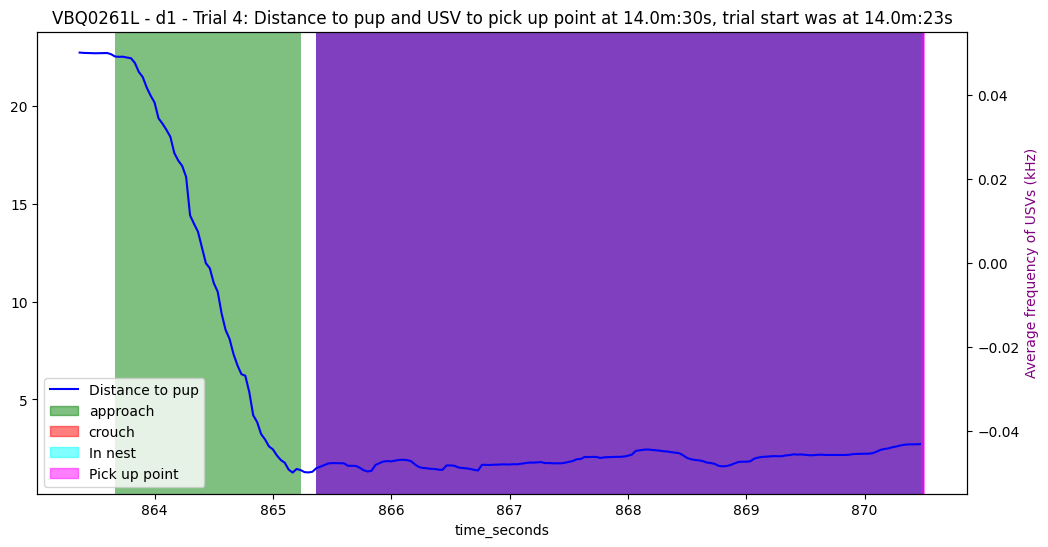

No pick up point for trial 5
No pick up point for trial 6
No pick up point for trial 7
No pick up point for trial 8
VBQ0261L Day d1 - Trial 9 was not successful
Approach count: 42
Crouching count: 147
Caring count: 173


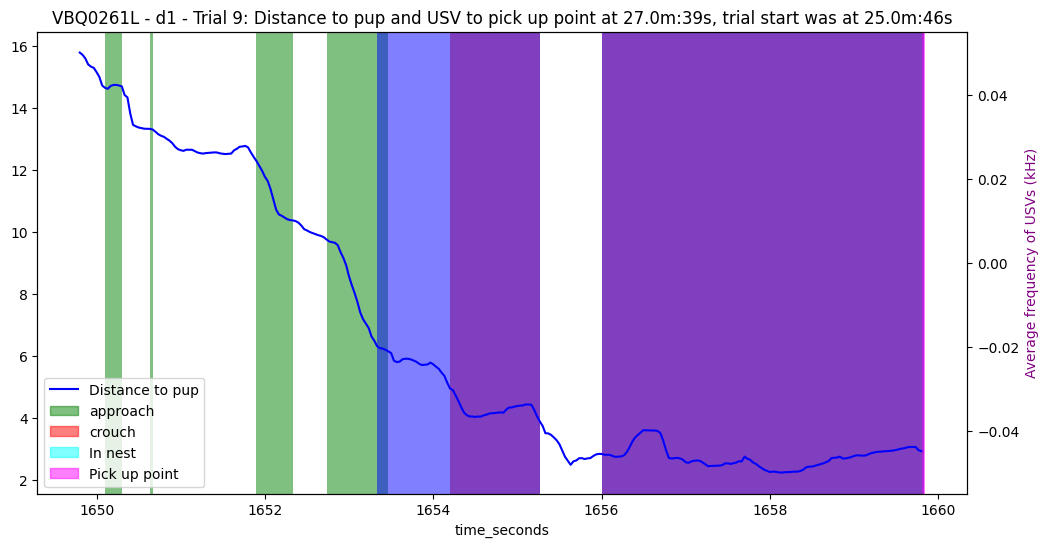

No pick up point for trial 10
No pick up point for trial 1
No pick up point for trial 2
No pick up point for trial 3
Approach count: 49
Crouching count: 0
Caring count: 8


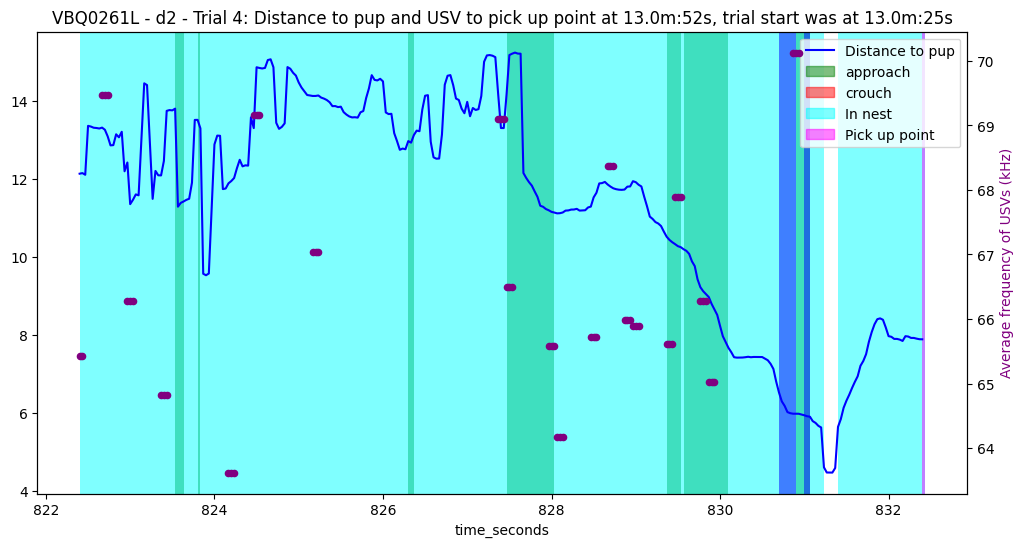

VBQ0261L Day d2 - Trial 5 was not successful
Approach count: 0
Crouching count: 124
Caring count: 124


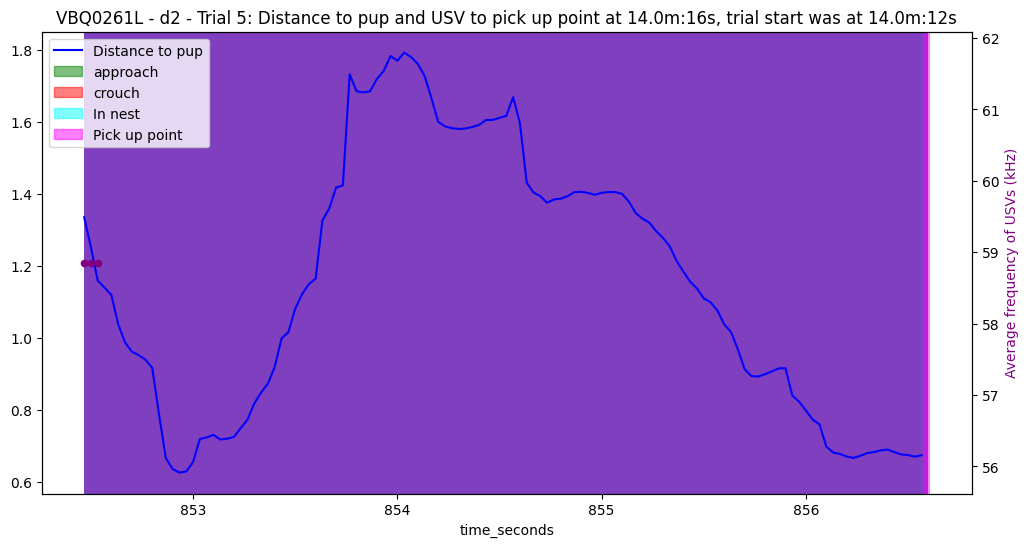

VBQ0261L Day d2 - Trial 6 was not successful
Approach count: 58
Crouching count: 39
Caring count: 39


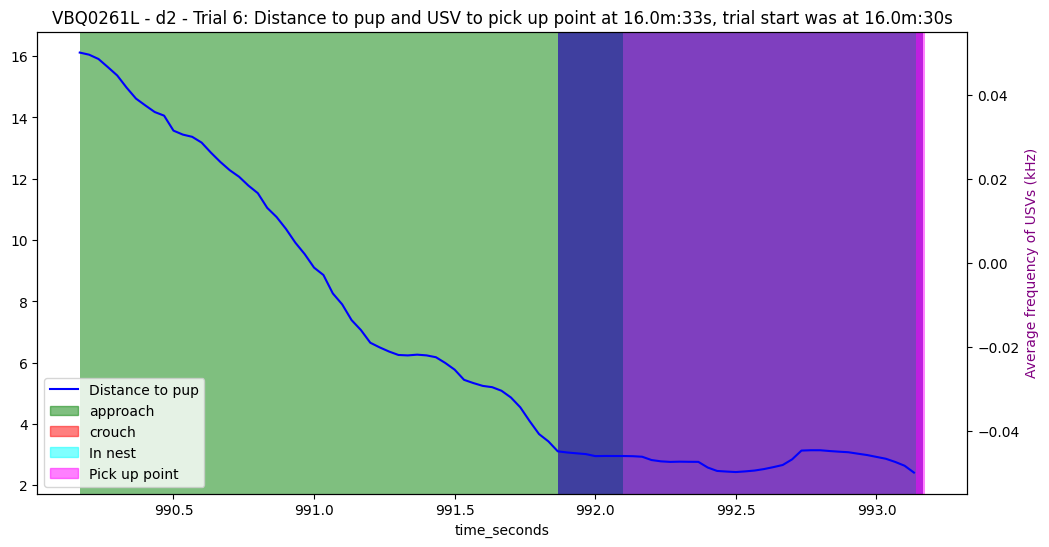

Approach count: 68
Crouching count: 61
Caring count: 81


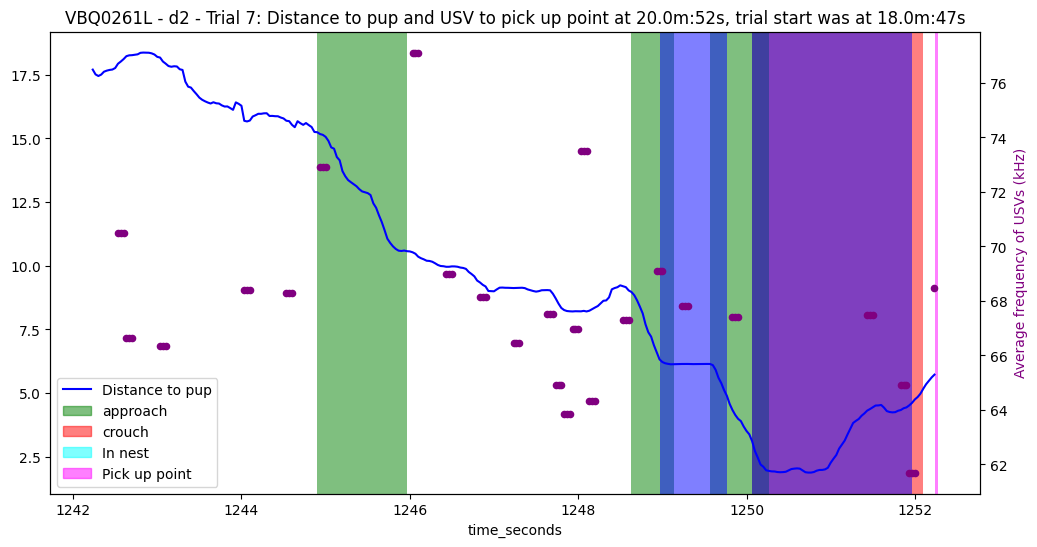

No pick up point for trial 8
Approach count: 32
Crouching count: 0
Caring count: 8


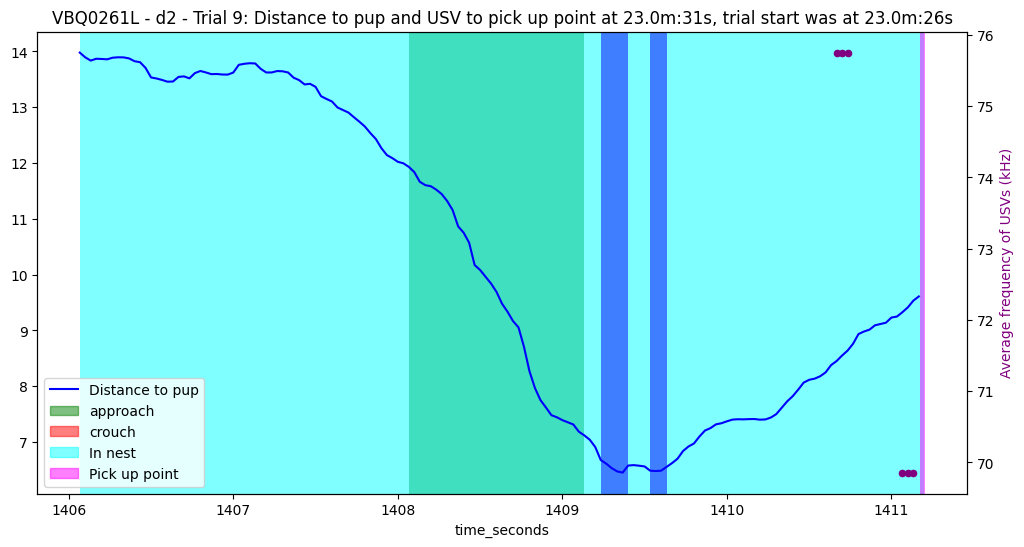

VBQ0261L Day d2 - Trial 10 was not successful
Approach count: 46
Crouching count: 72
Caring count: 72


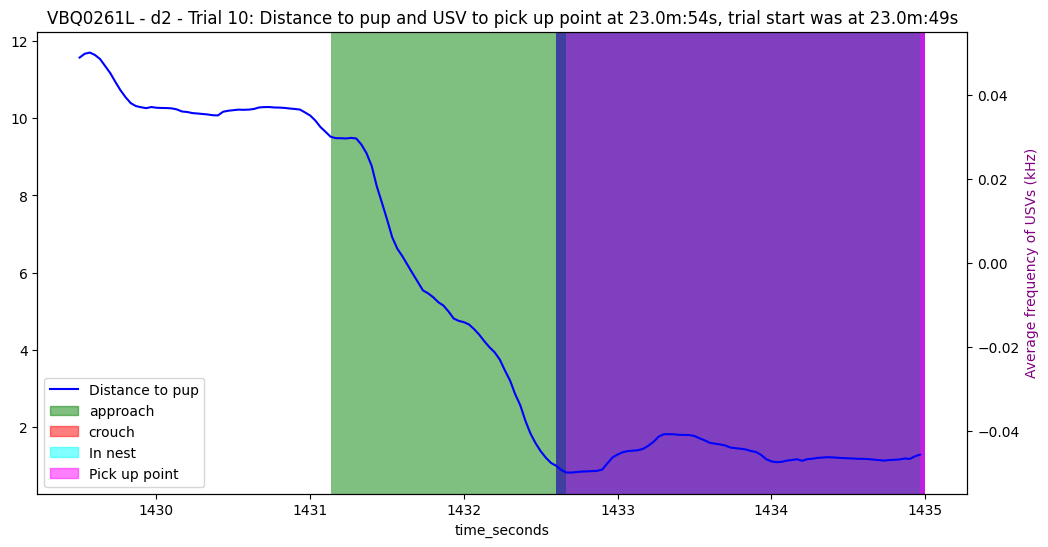

No pick up point for trial 1
No pick up point for trial 2
No pick up point for trial 3
Approach count: 53
Crouching count: 89
Caring count: 89


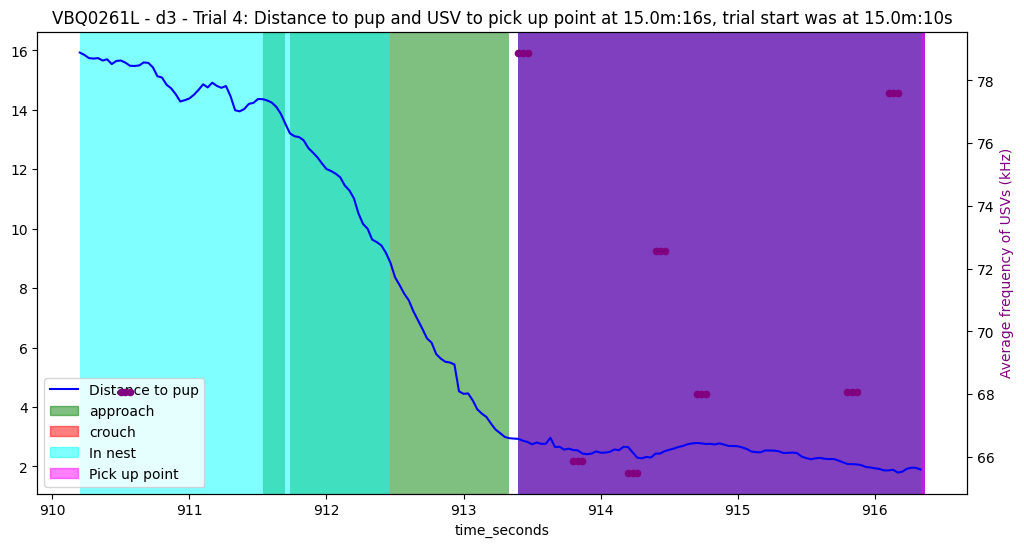

No pick up point for trial 5
Approach count: 55
Crouching count: 15
Caring count: 28


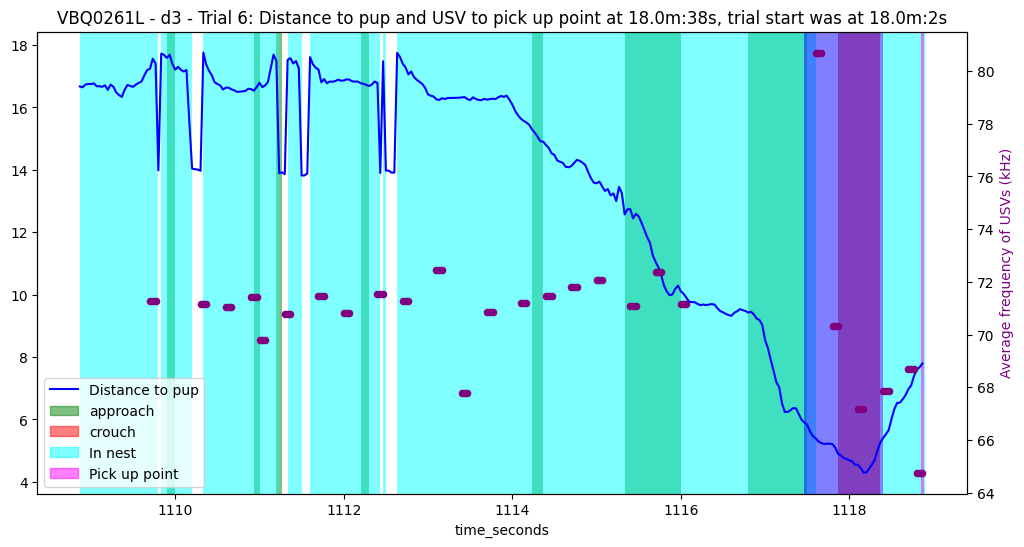

Approach count: 67
Crouching count: 33
Caring count: 33


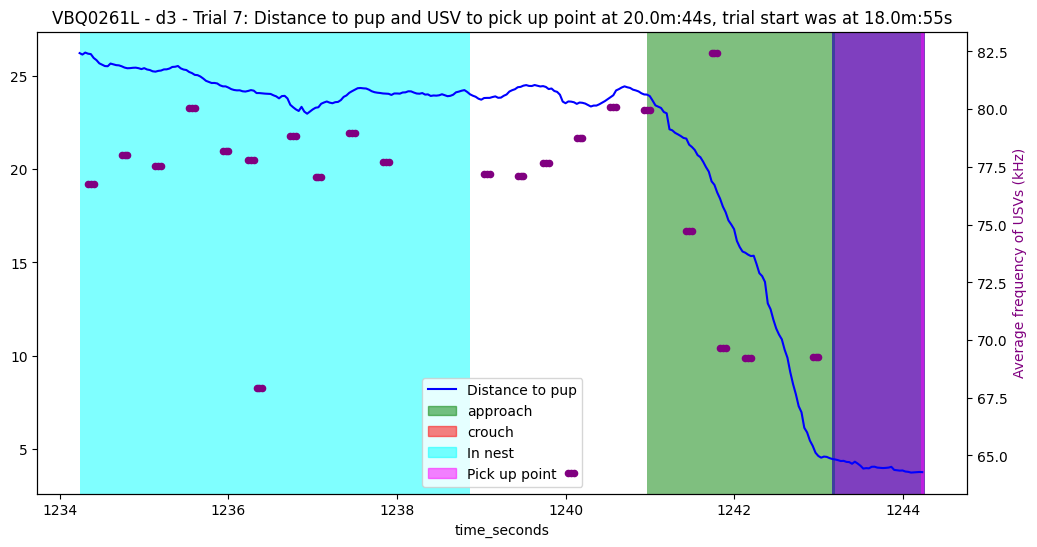

VBQ0261L Day d3 - Trial 8 was not successful
Approach count: 52
Crouching count: 100
Caring count: 100


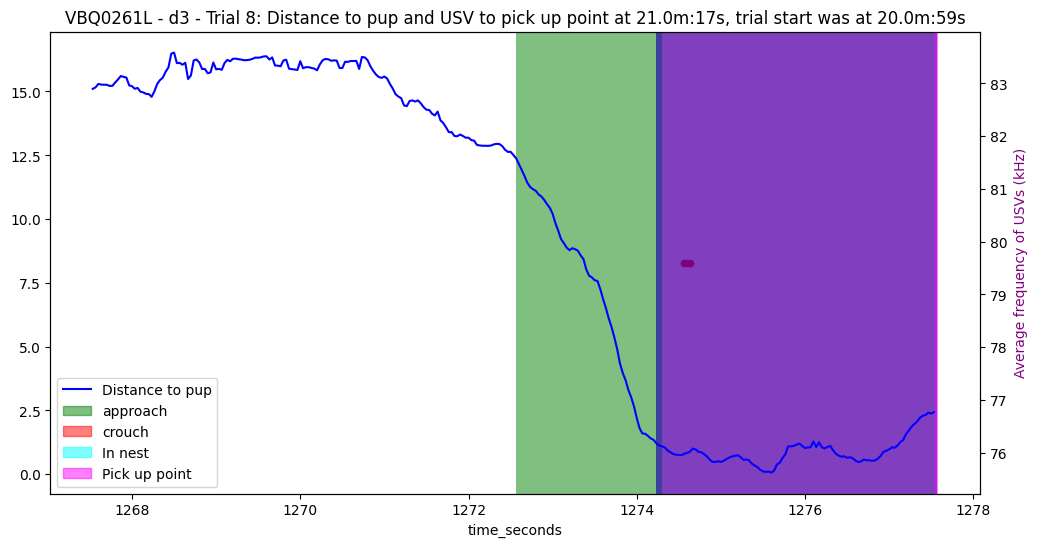

No pick up point for trial 9
Approach count: 0
Crouching count: 49
Caring count: 49


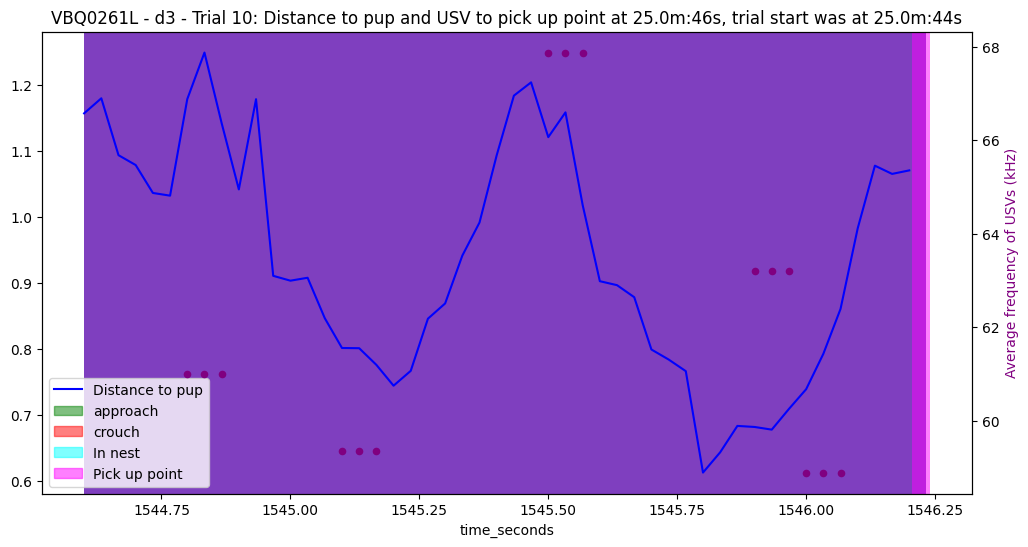

Approach count: 76
Crouching count: 29
Caring count: 39


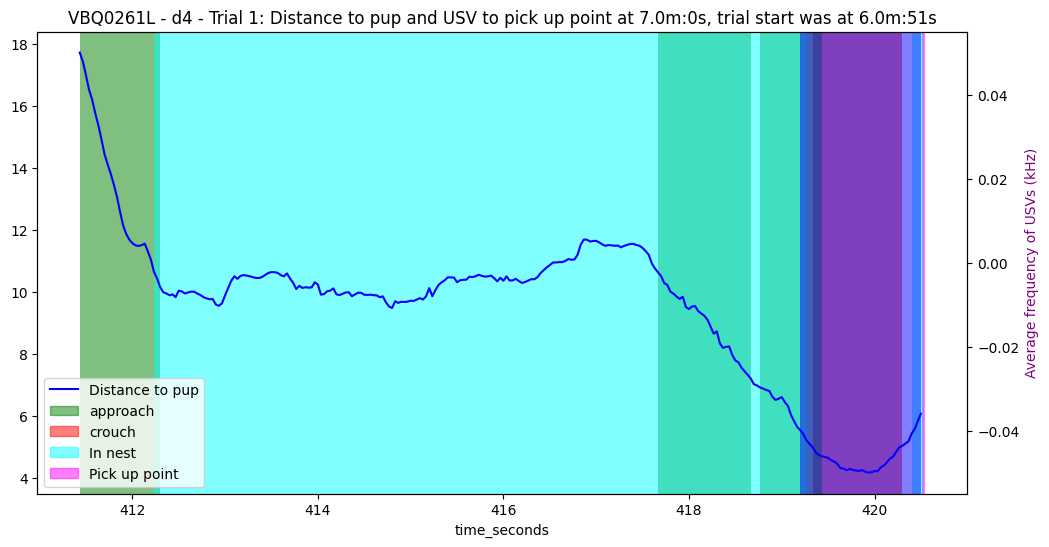

No pick up point for trial 2
Approach count: 97
Crouching count: 26
Caring count: 26


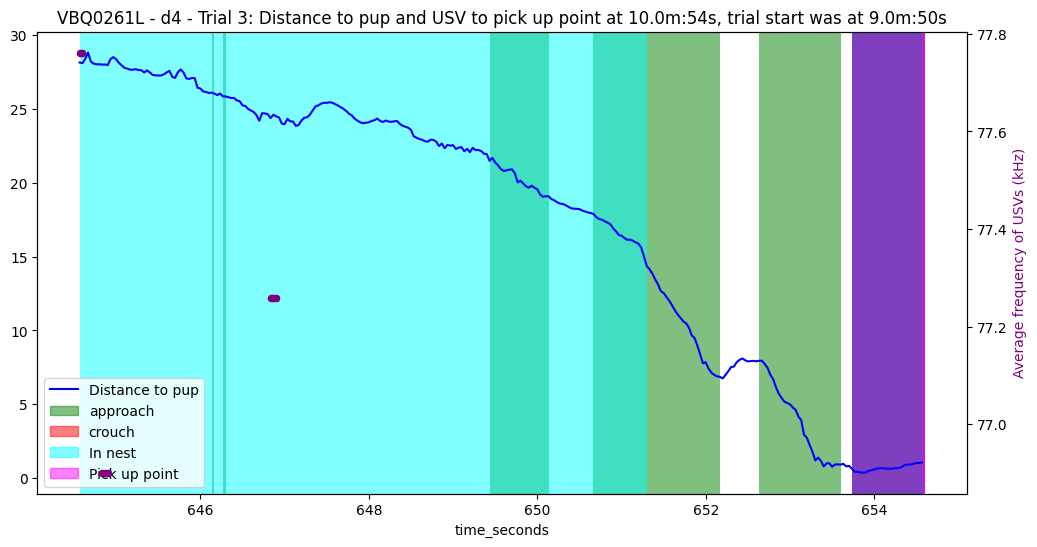

Approach count: 47
Crouching count: 11
Caring count: 11


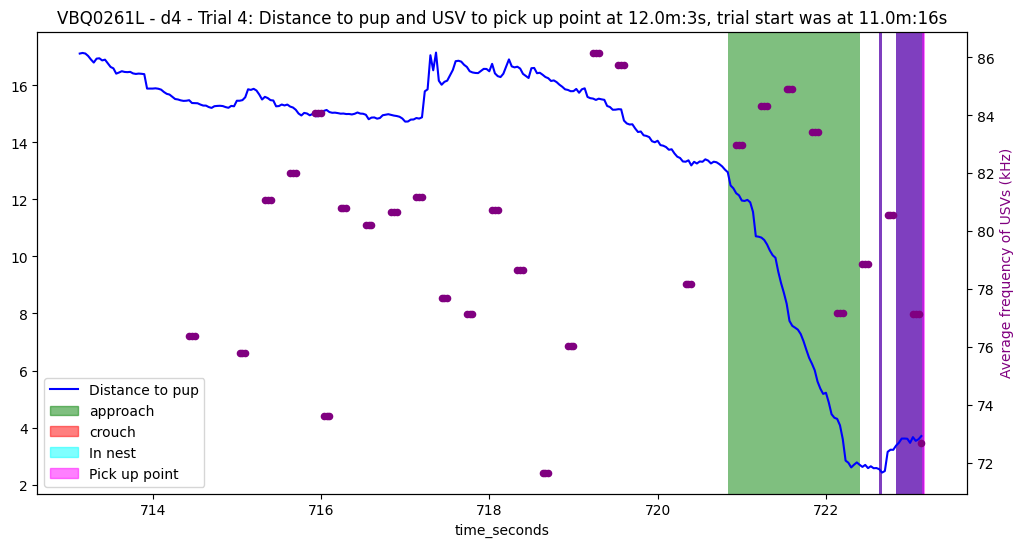

No pick up point for trial 5
Approach count: 53
Crouching count: 29
Caring count: 29


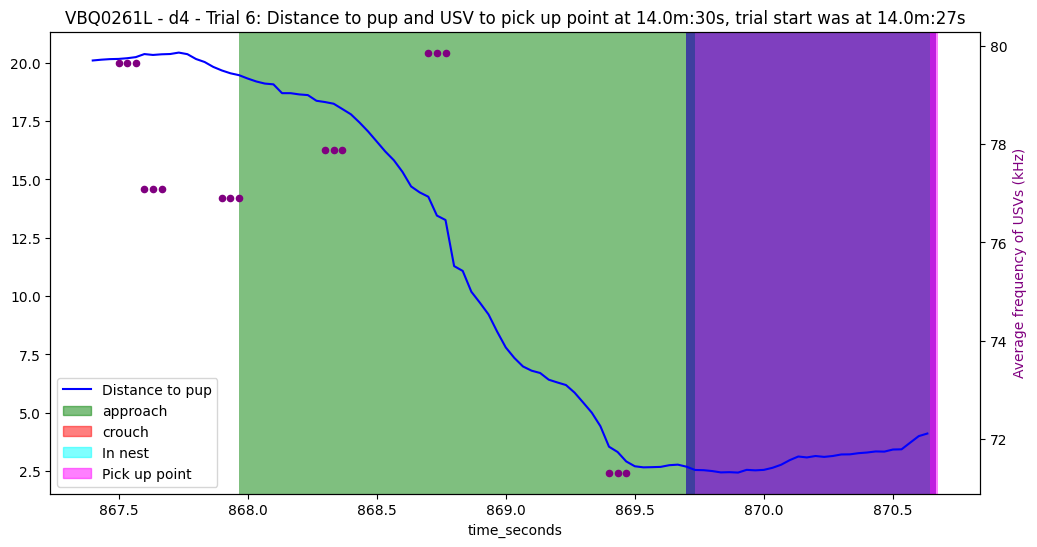

VBQ0261L Day d4 - Trial 7 was not successful
Approach count: 8
Crouching count: 220
Caring count: 210


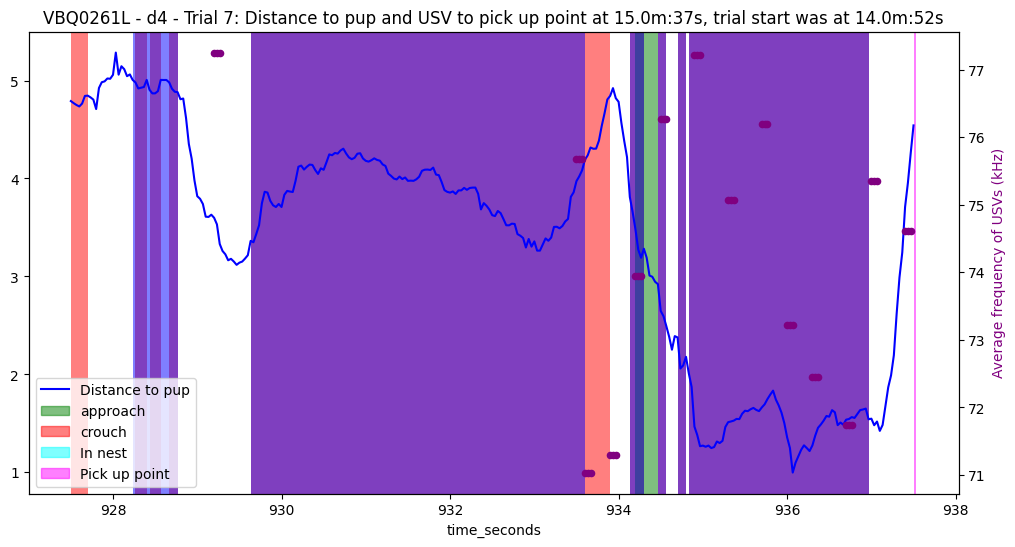

Approach count: 97
Crouching count: 23
Caring count: 23


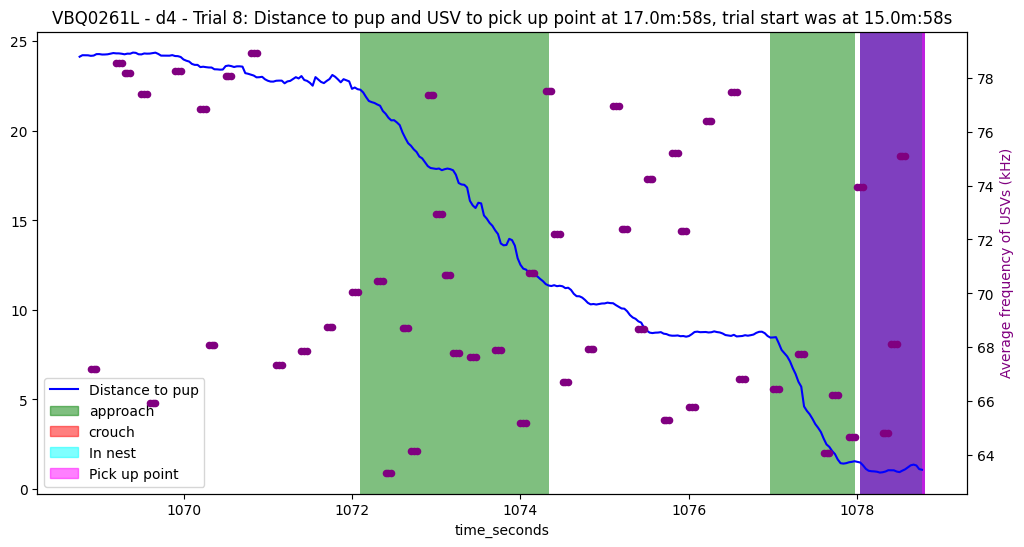

No pick up point for trial 9
No pick up point for trial 10
No pick up point for trial 1
No pick up point for trial 2
Approach count: 64
Crouching count: 0
Caring count: 0


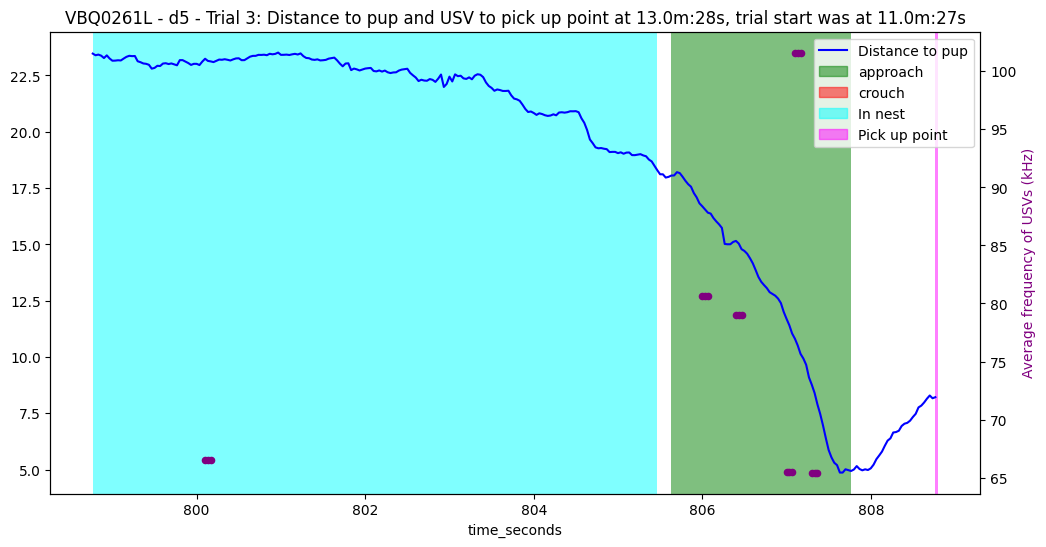

No pick up point for trial 4
No pick up point for trial 5
Approach count: 87
Crouching count: 0
Caring count: 10


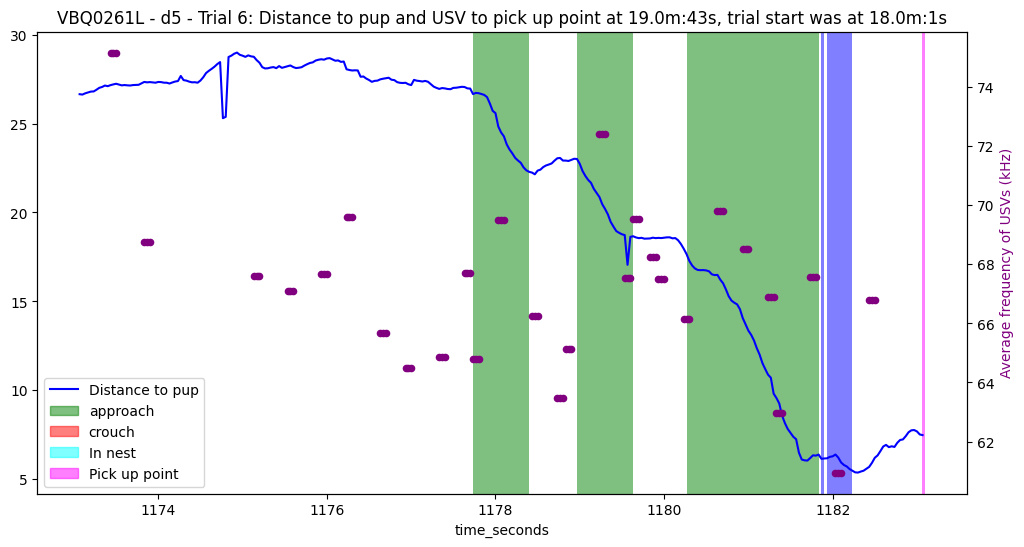

Approach count: 79
Crouching count: 1
Caring count: 1


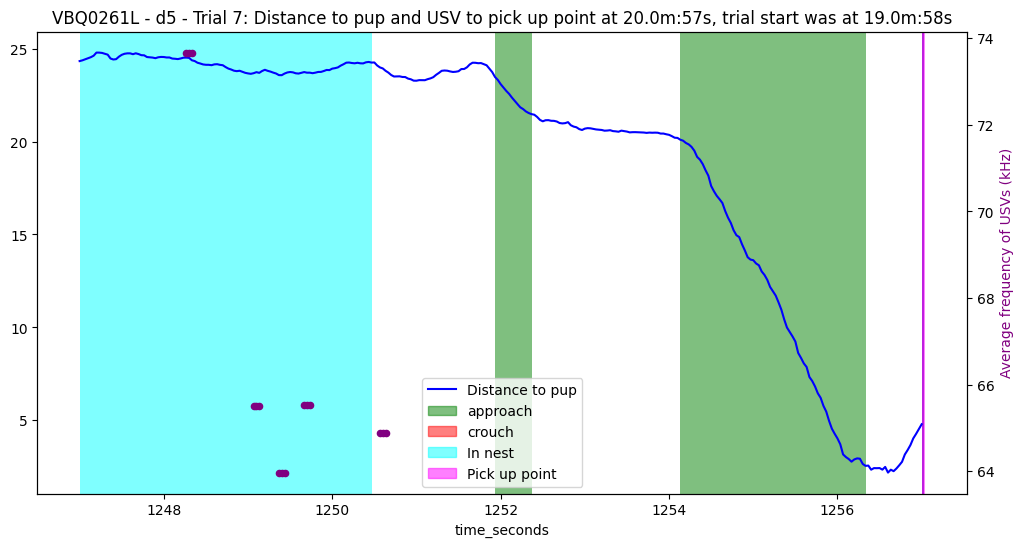

Approach count: 90
Crouching count: 4
Caring count: 4


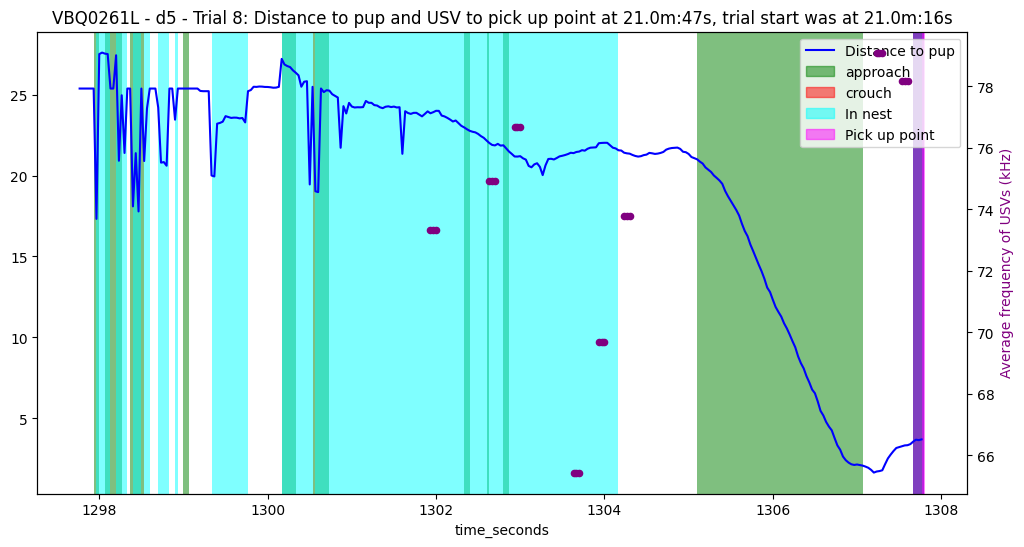

Approach count: 103
Crouching count: 69
Caring count: 69


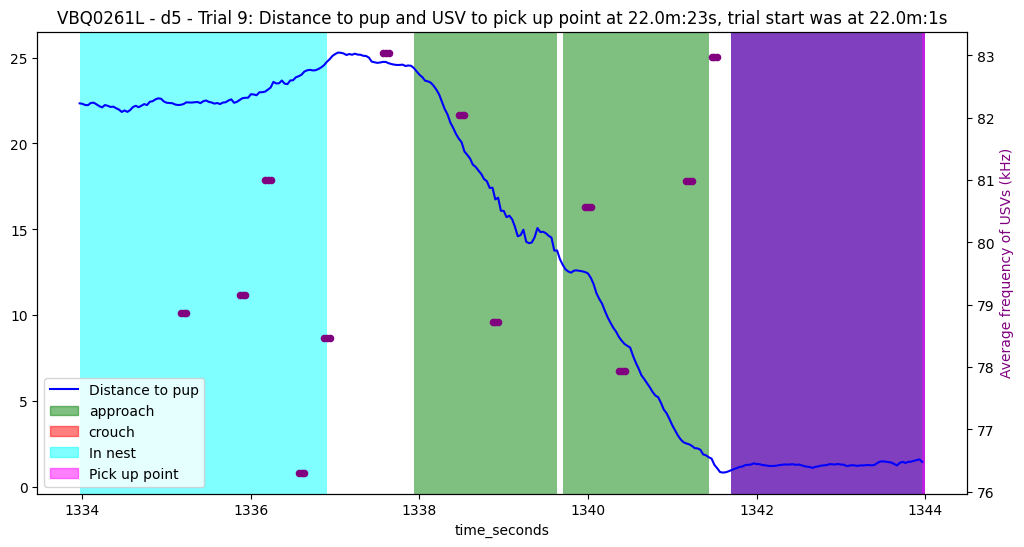

No pick up point for trial 10
No pick up point for trial 1
No pick up point for trial 2
No pick up point for trial 3
No pick up point for trial 4
No pick up point for trial 5
No pick up point for trial 6
Approach count: 90
Crouching count: 65
Caring count: 65


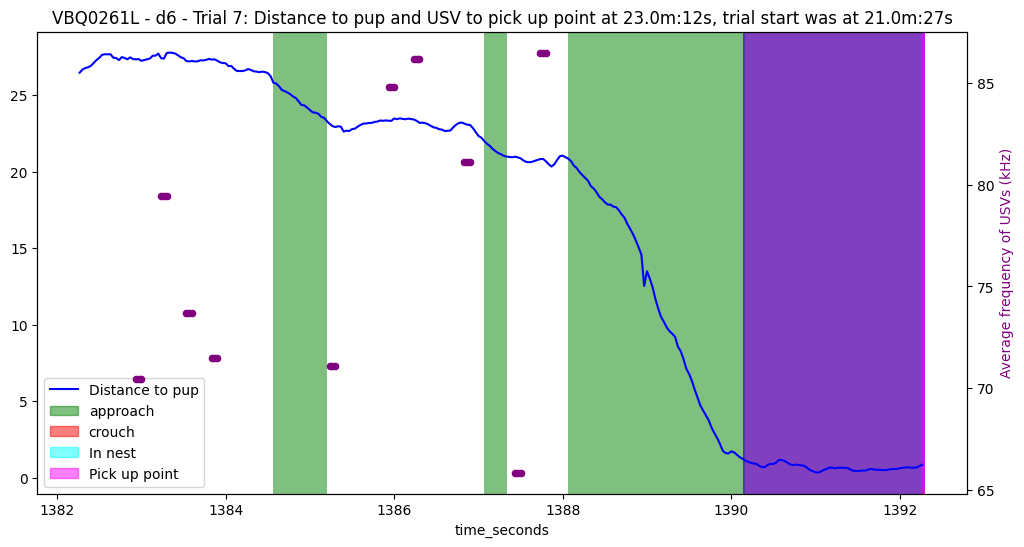

Approach count: 90
Crouching count: 29
Caring count: 30


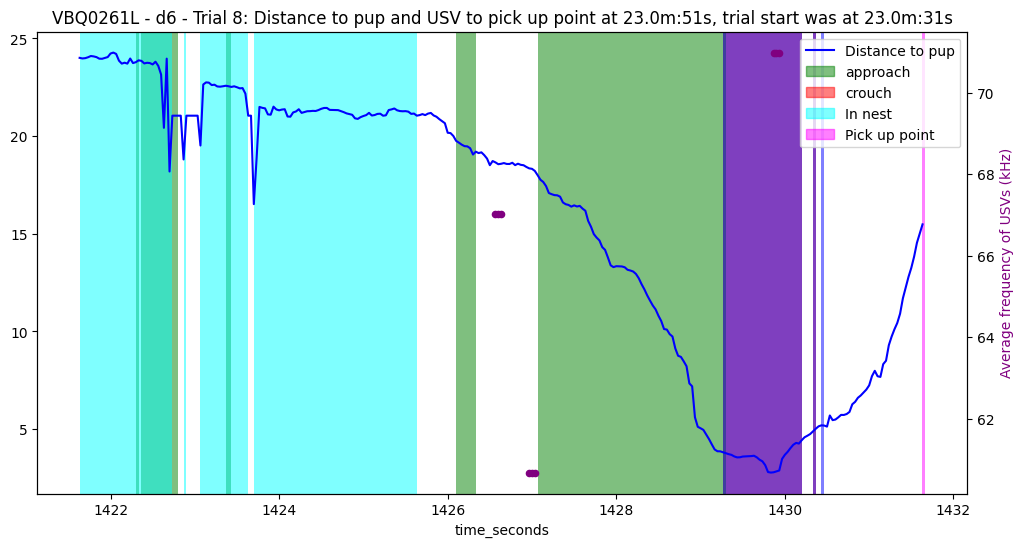

Approach count: 63
Crouching count: 16
Caring count: 16


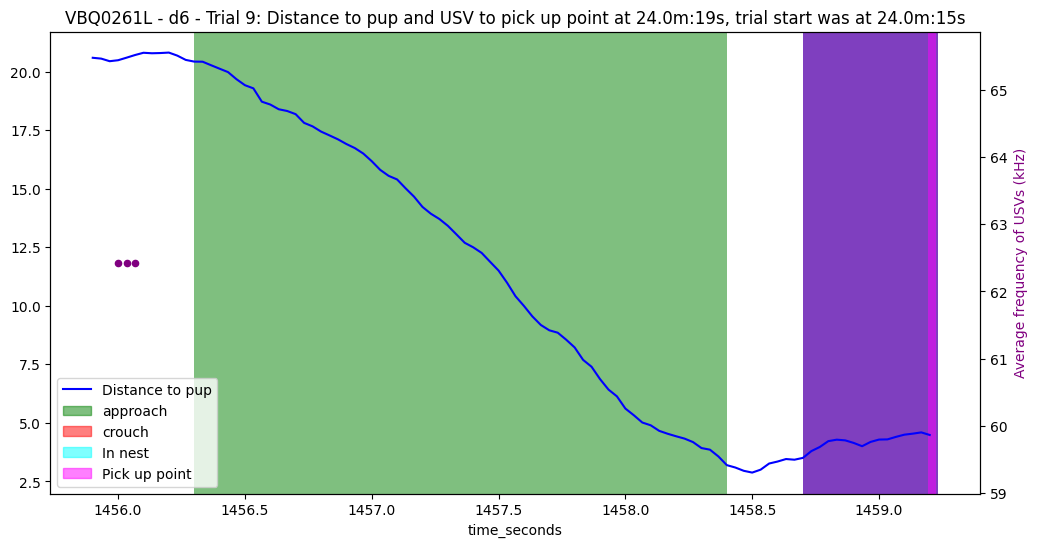

No pick up point for trial 10
Approach count: 98
Crouching count: 58
Caring count: 58


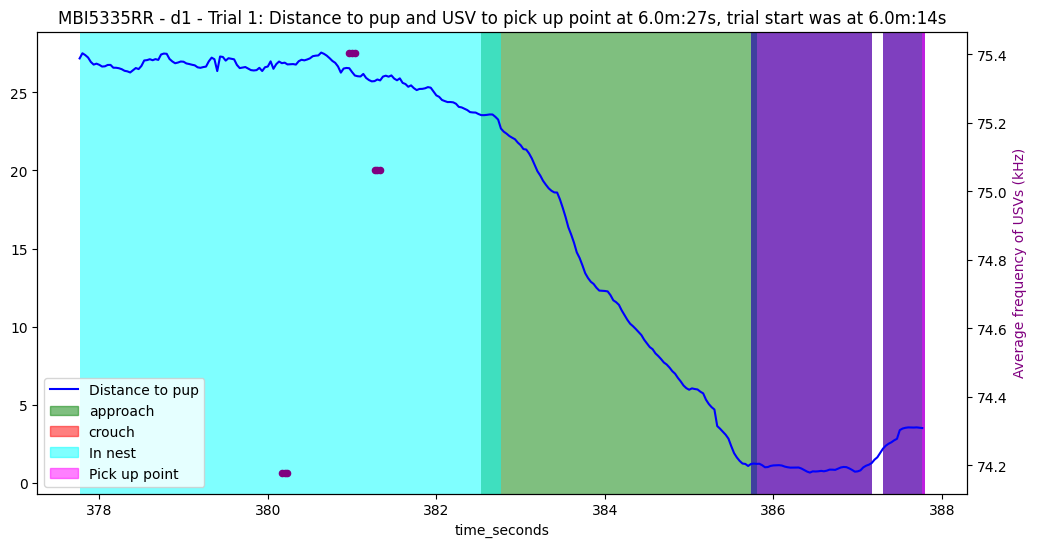

Approach count: 21
Crouching count: 38
Caring count: 62


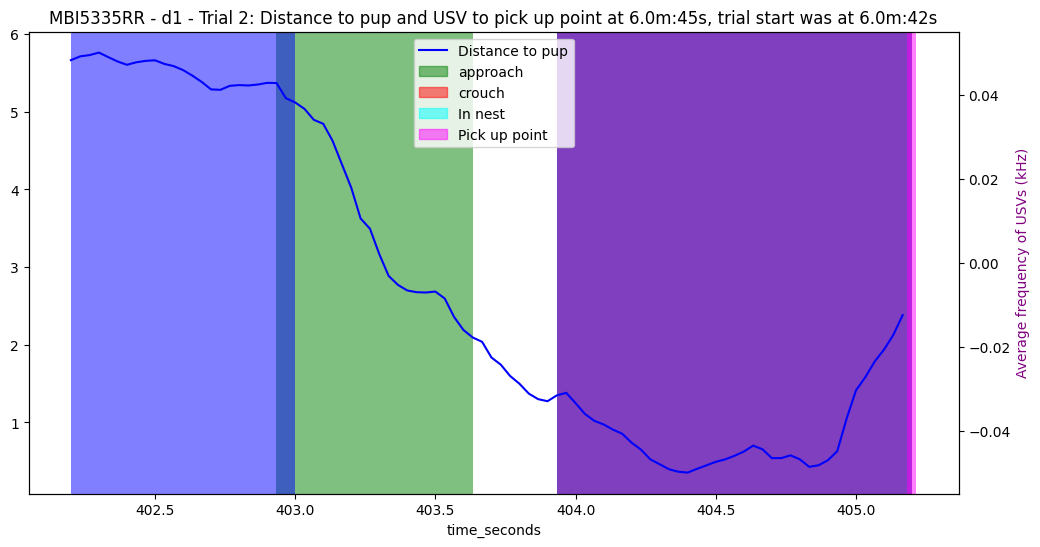

Approach count: 53
Crouching count: 69
Caring count: 69


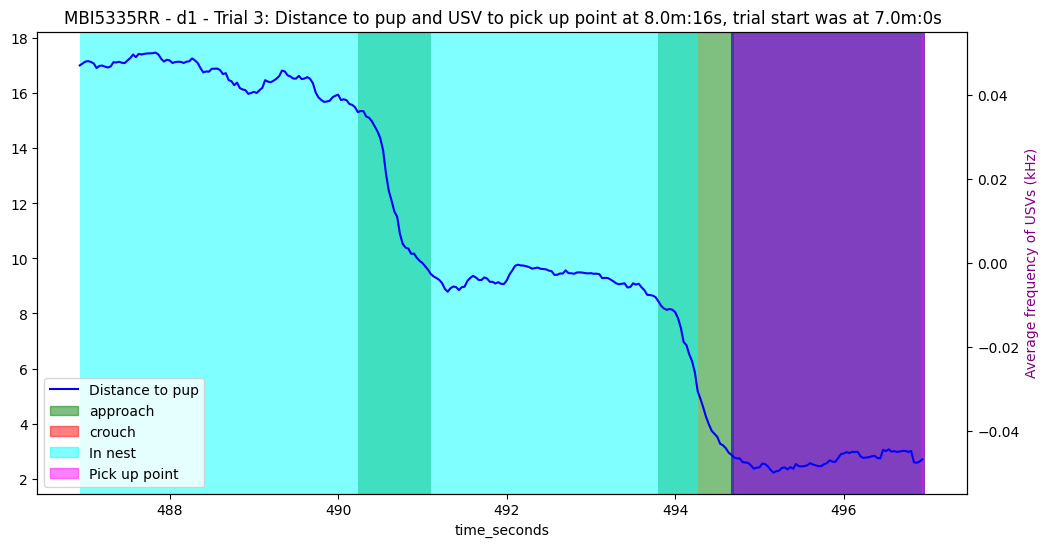

Approach count: 65
Crouching count: 29
Caring count: 29


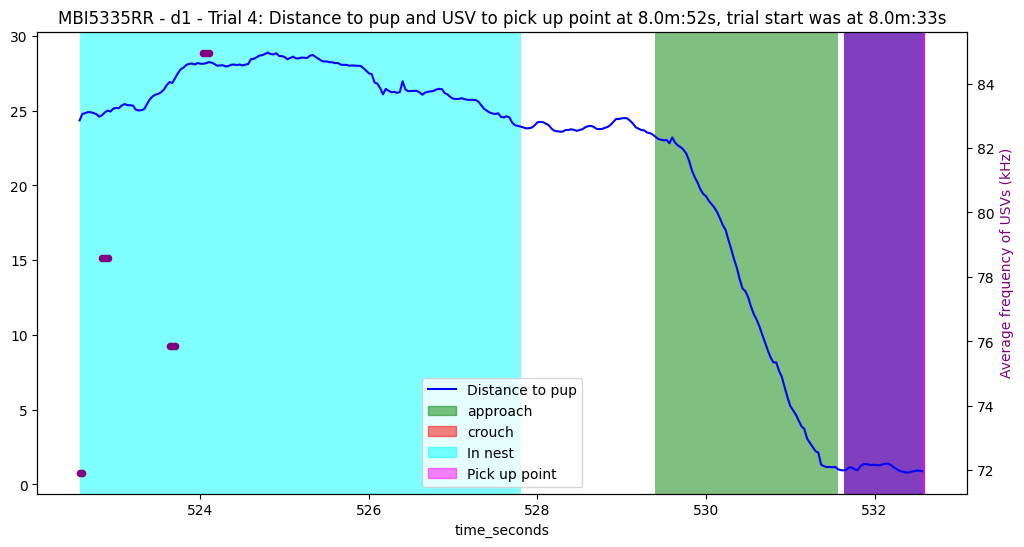

Approach count: 58
Crouching count: 24
Caring count: 24


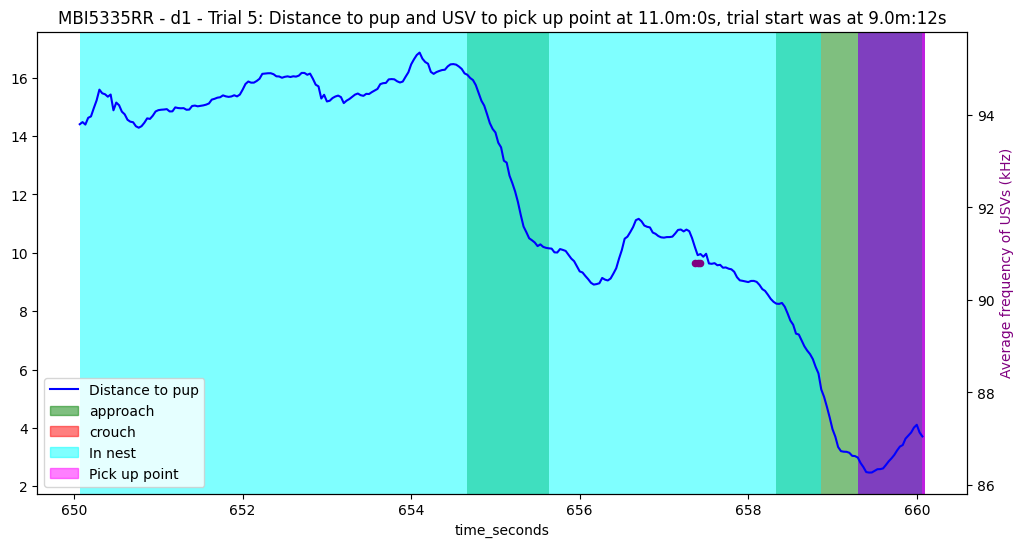

Approach count: 80
Crouching count: 80
Caring count: 80


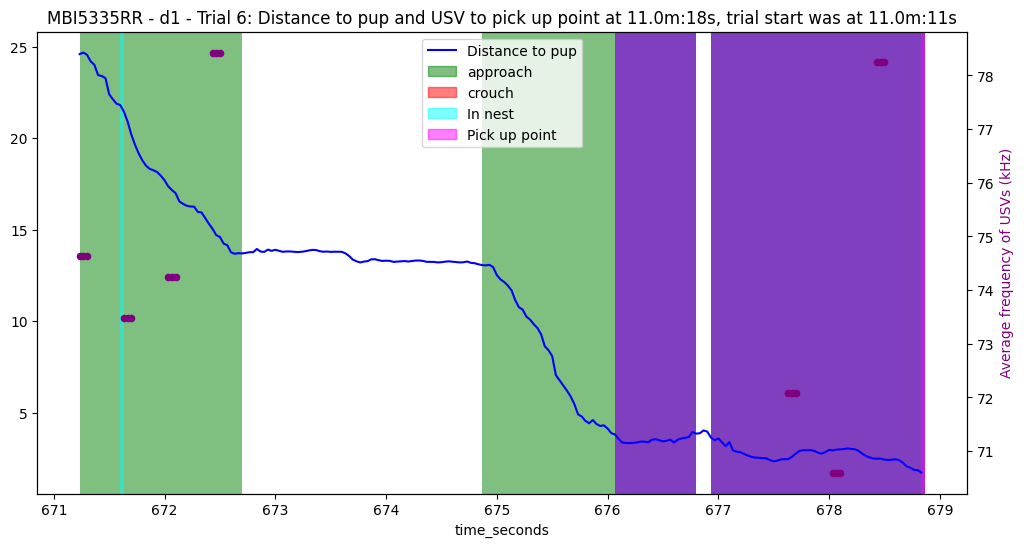

Approach count: 68
Crouching count: 39
Caring count: 39


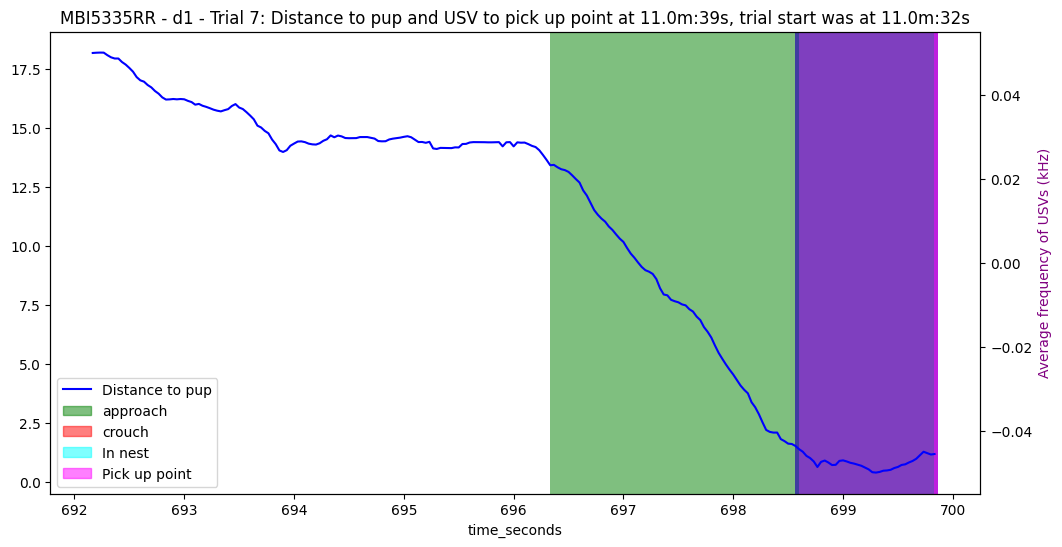

Approach count: 97
Crouching count: 32
Caring count: 31


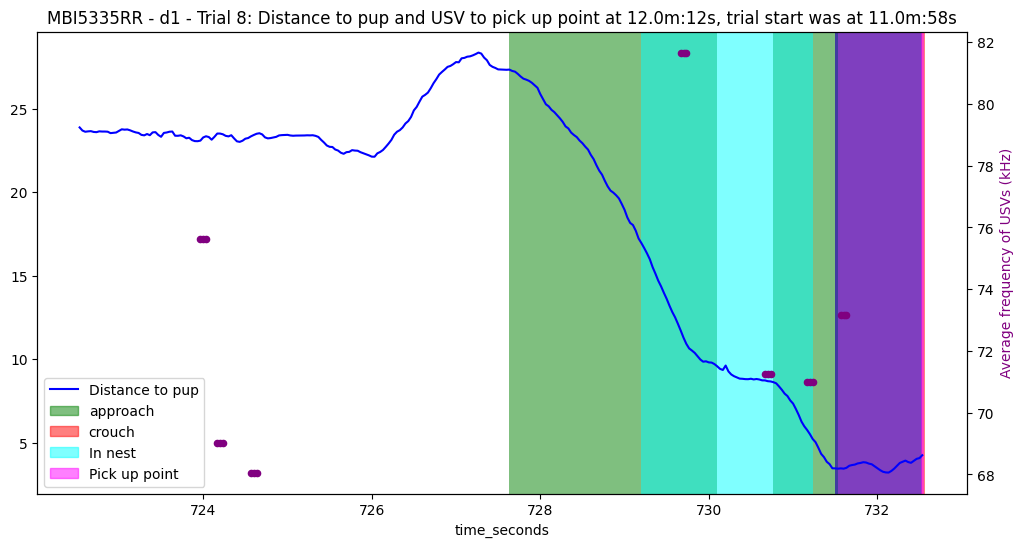

Approach count: 95
Crouching count: 30
Caring count: 30


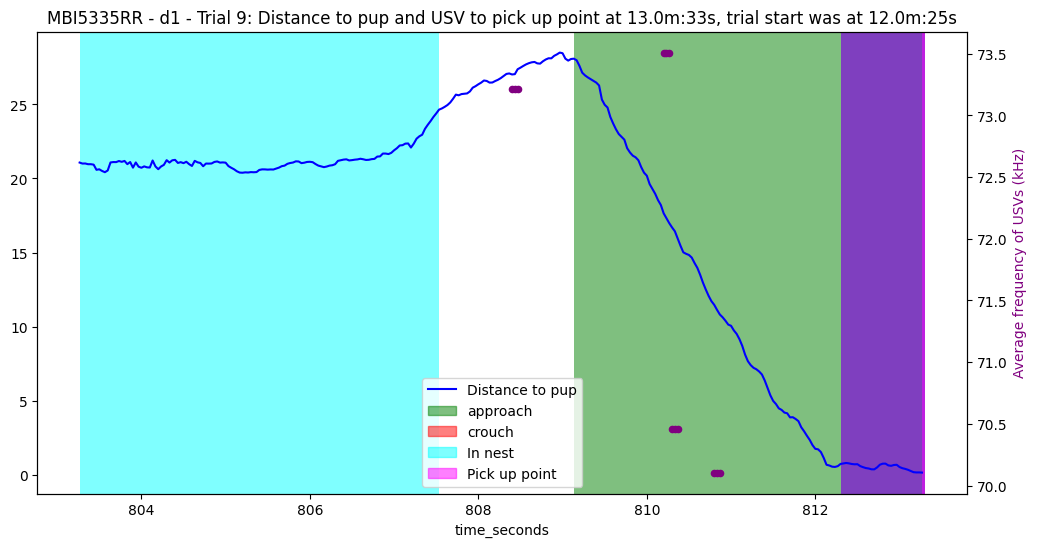

Approach count: 111
Crouching count: 34
Caring count: 34


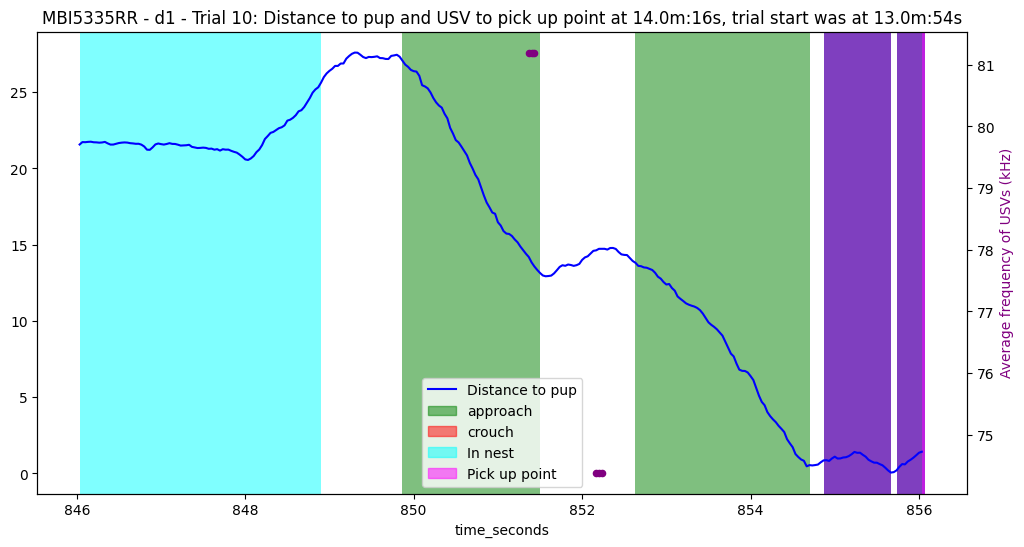

Approach count: 85
Crouching count: 7
Caring count: 38


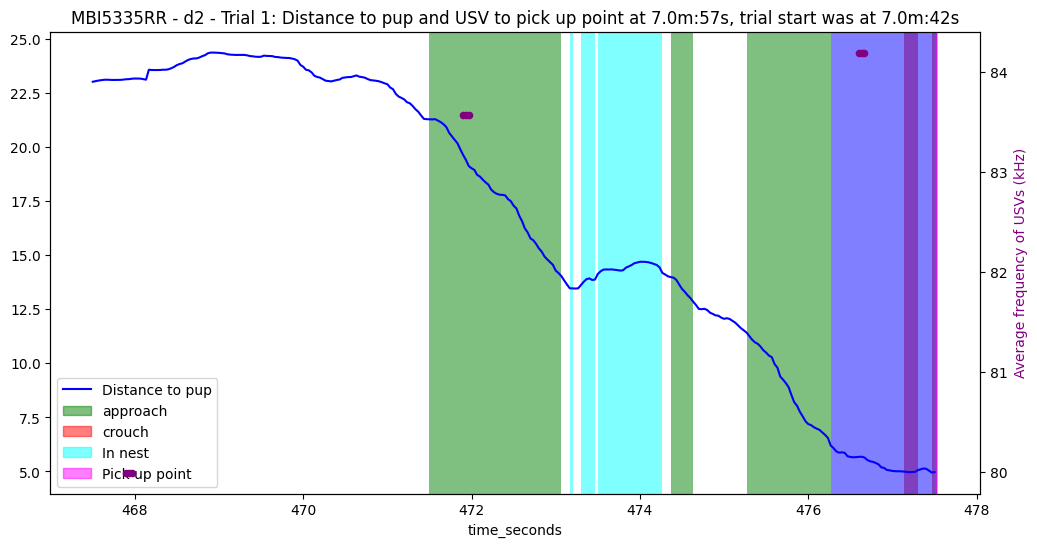

Approach count: 70
Crouching count: 38
Caring count: 38


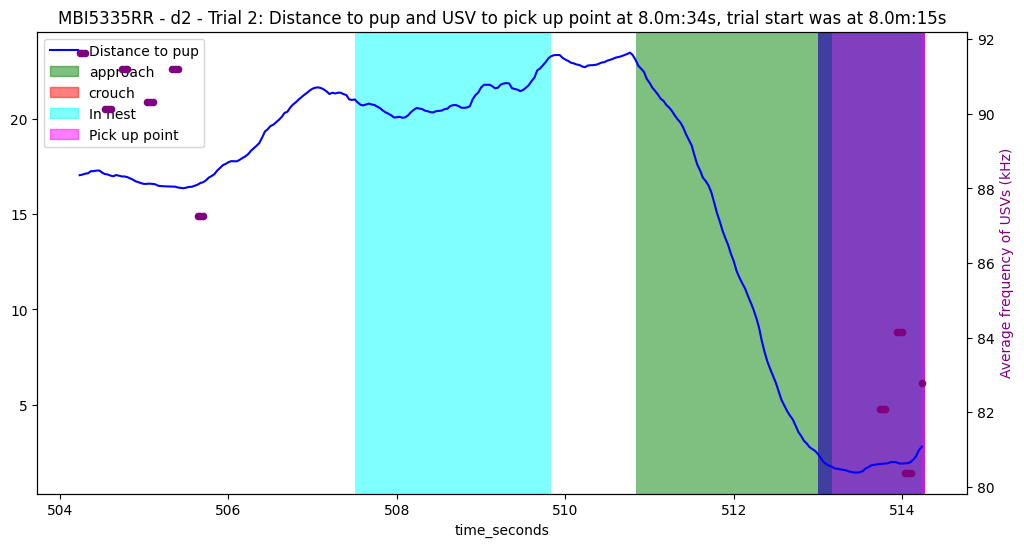

Approach count: 74
Crouching count: 109
Caring count: 109


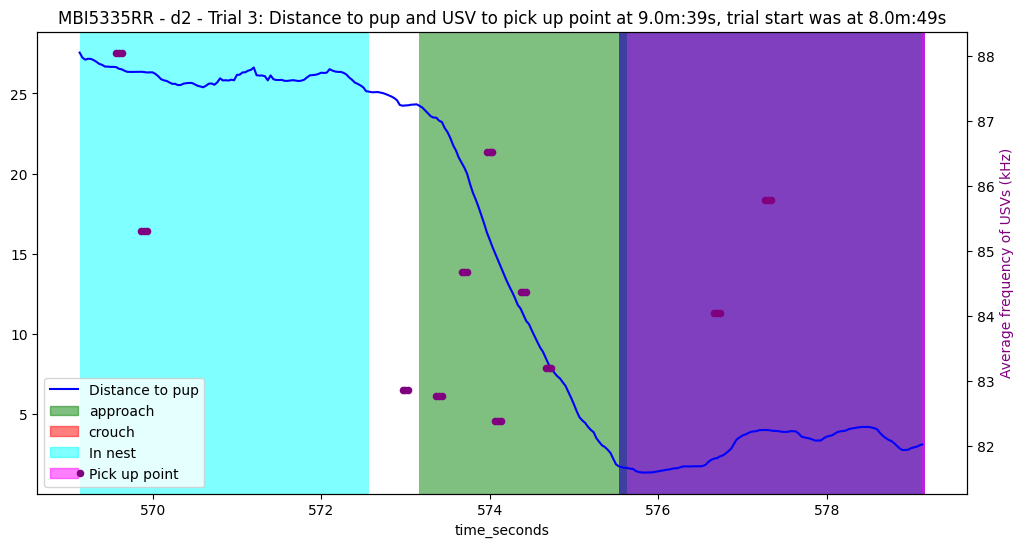

Approach count: 55
Crouching count: 100
Caring count: 99


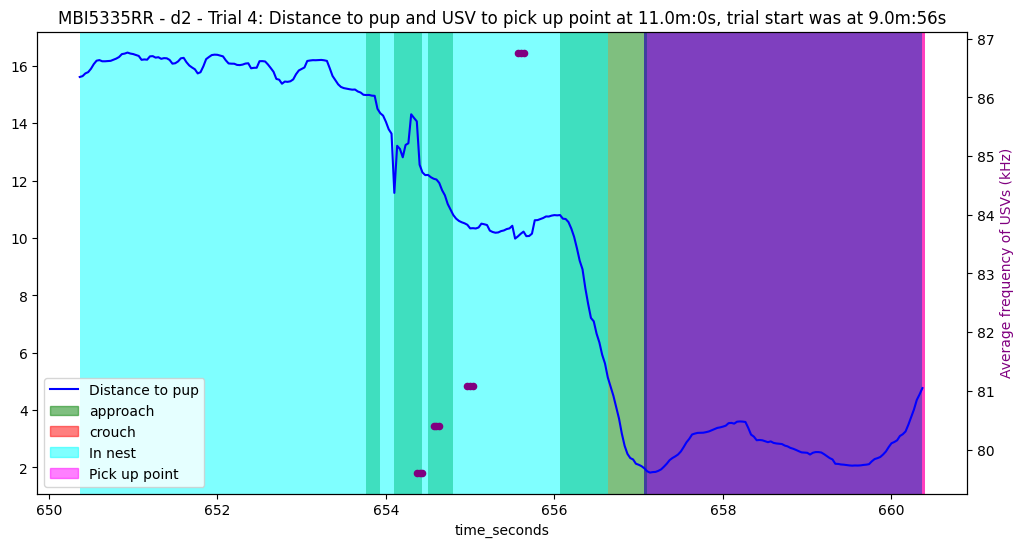

Approach count: 59
Crouching count: 42
Caring count: 42


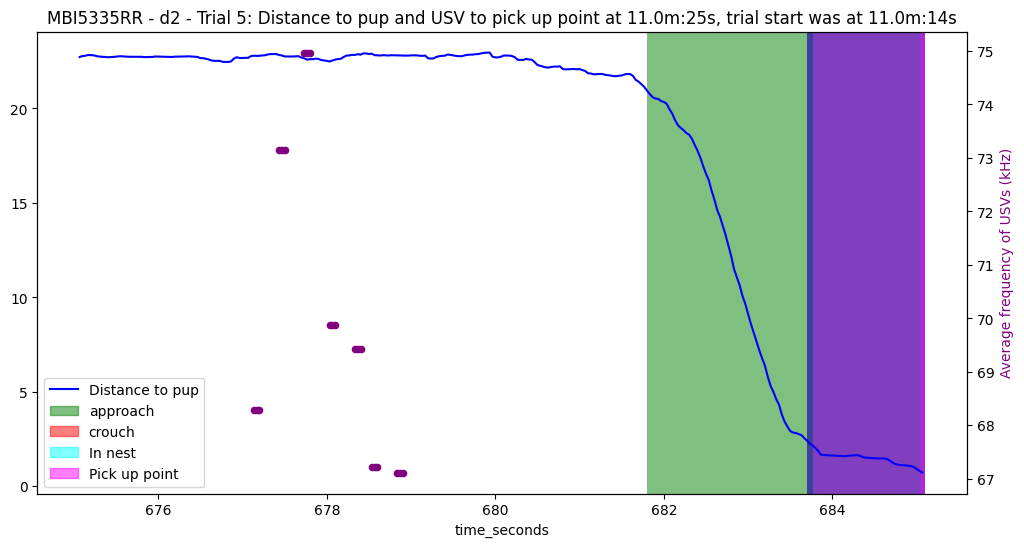

Approach count: 31
Crouching count: 31
Caring count: 31


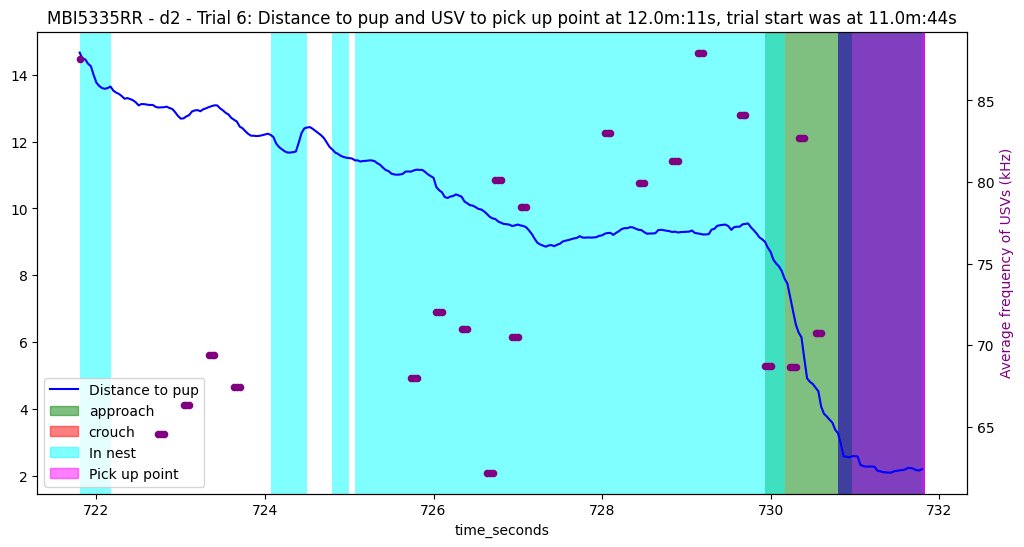

Approach count: 57
Crouching count: 68
Caring count: 68


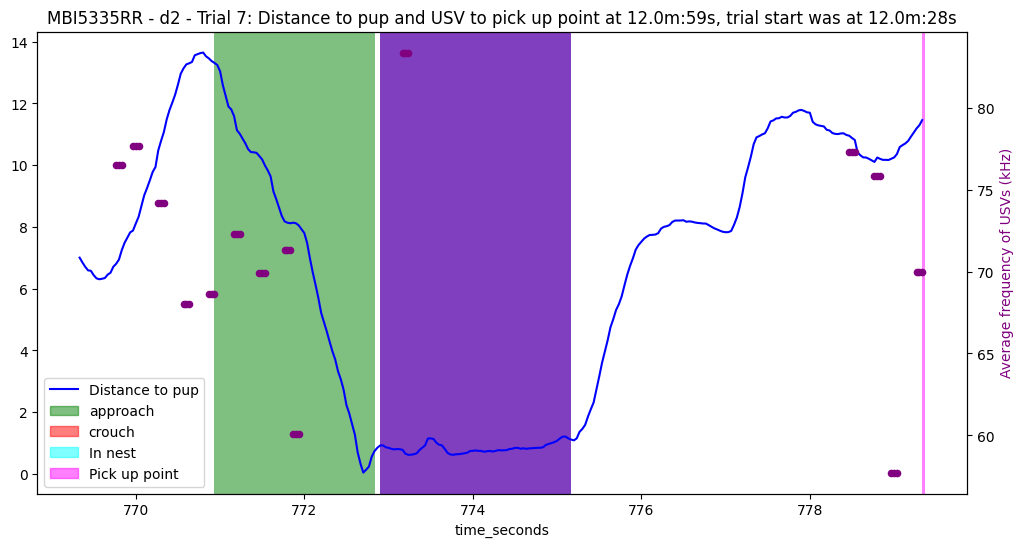

Approach count: 0
Crouching count: 82
Caring count: 82


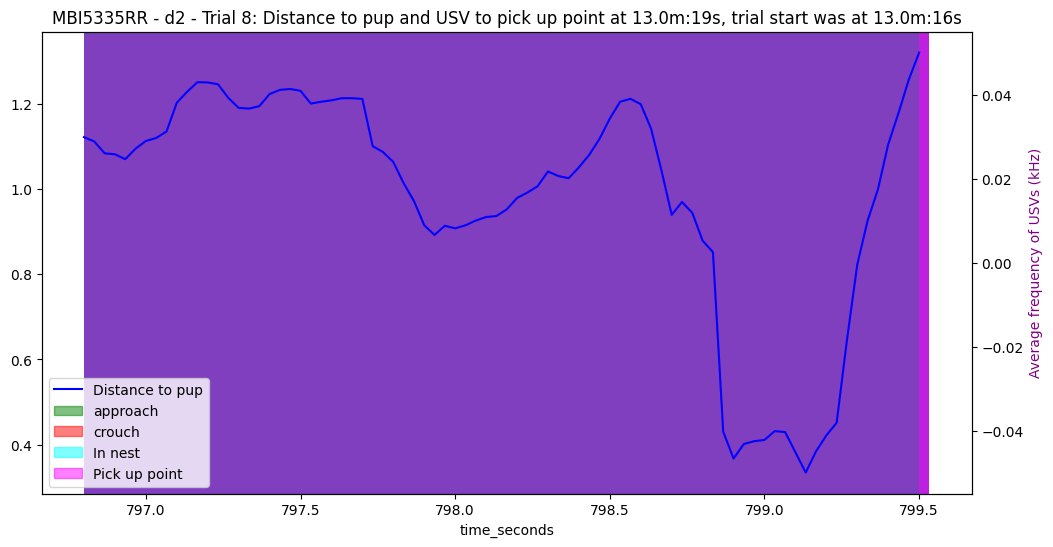

Approach count: 91
Crouching count: 20
Caring count: 32


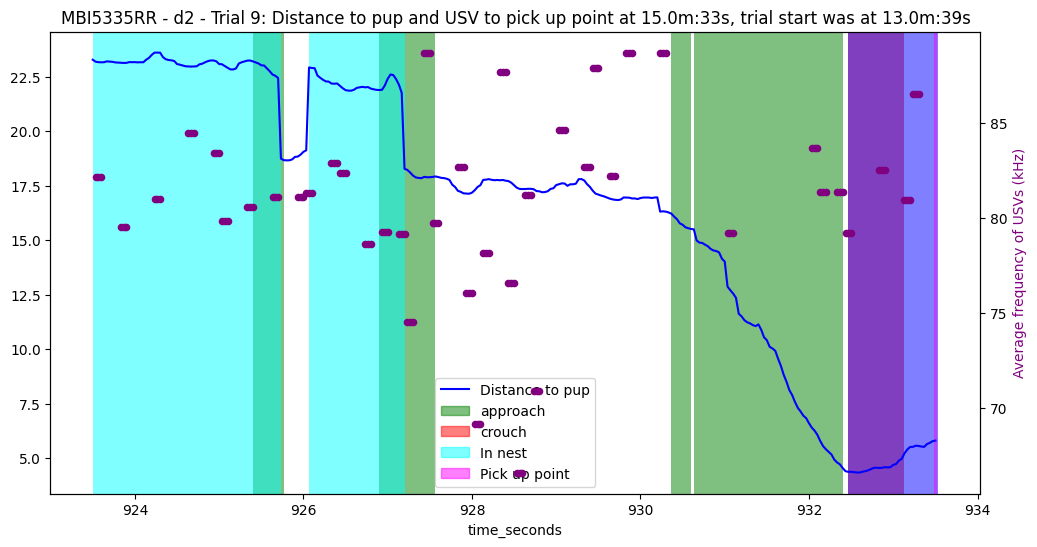

Approach count: 93
Crouching count: 23
Caring count: 23


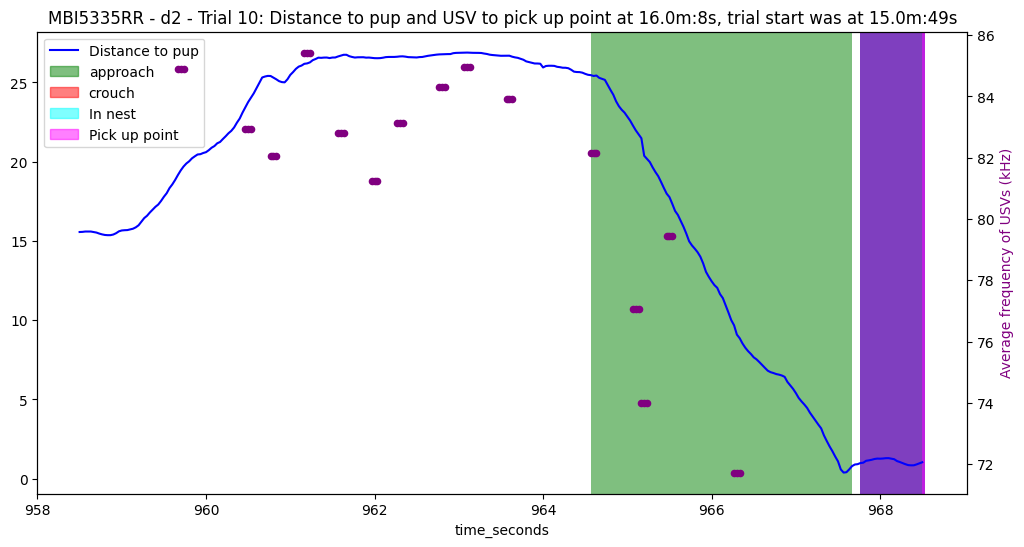

Approach count: 52
Crouching count: 77
Caring count: 96


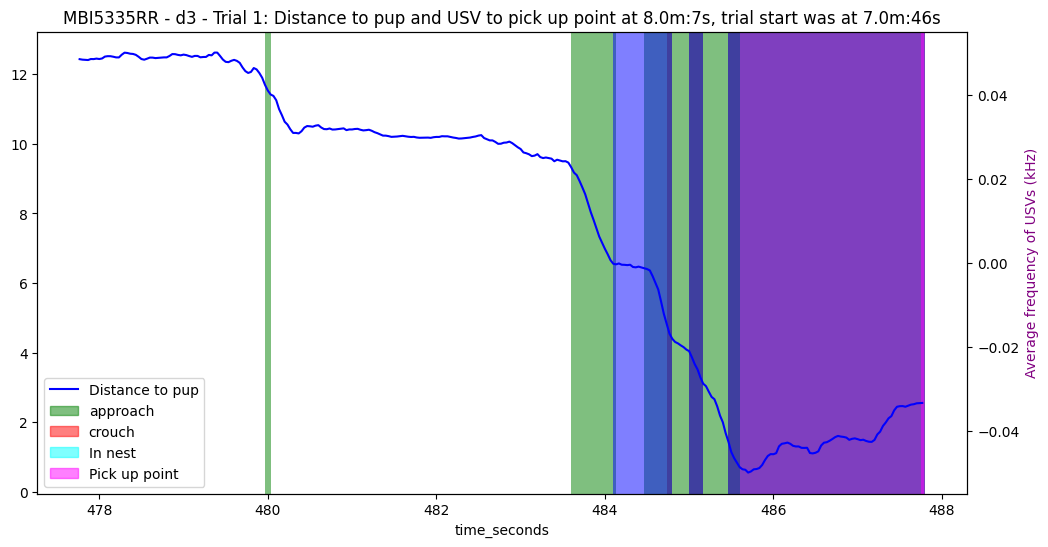

Approach count: 105
Crouching count: 31
Caring count: 31


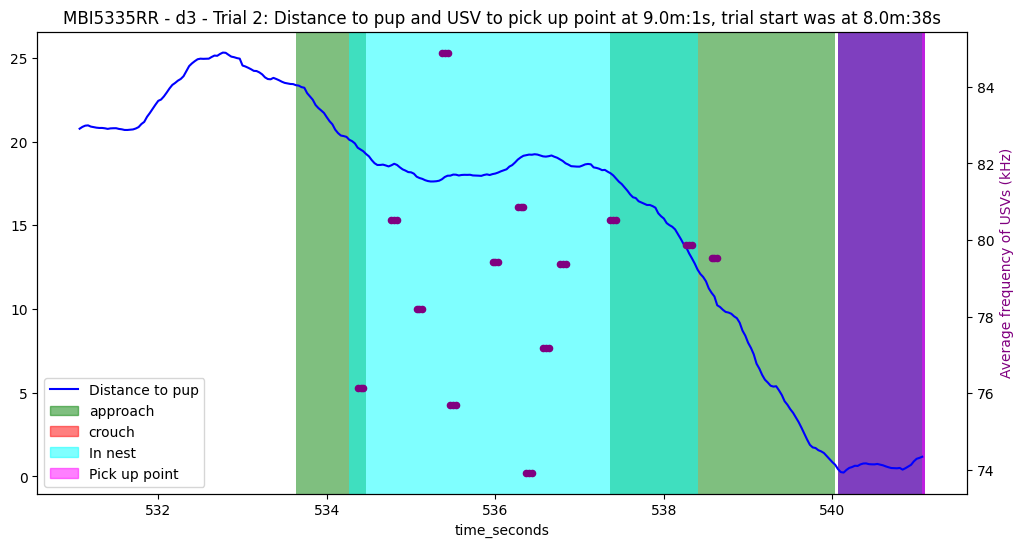

Approach count: 45
Crouching count: 71
Caring count: 71


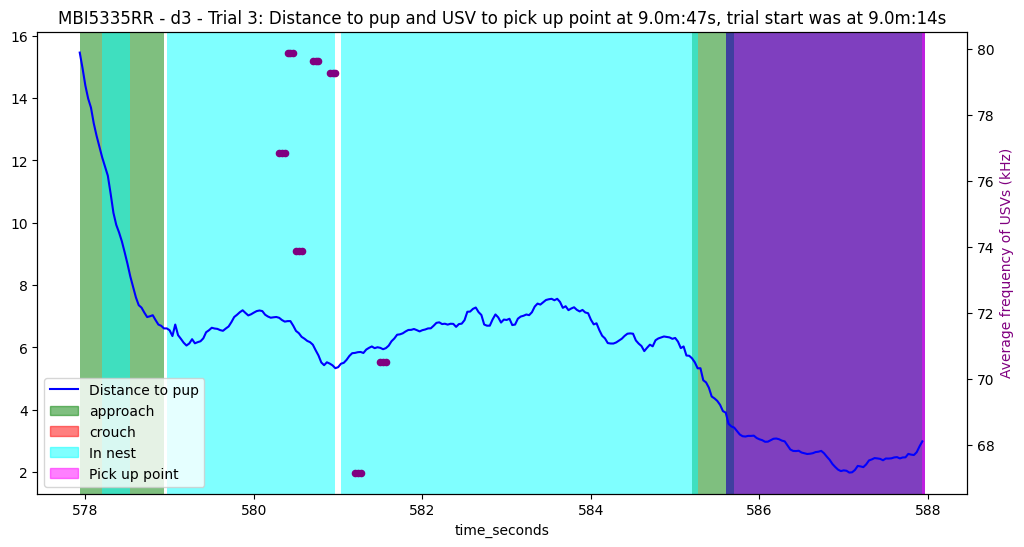

Approach count: 90
Crouching count: 34
Caring count: 34


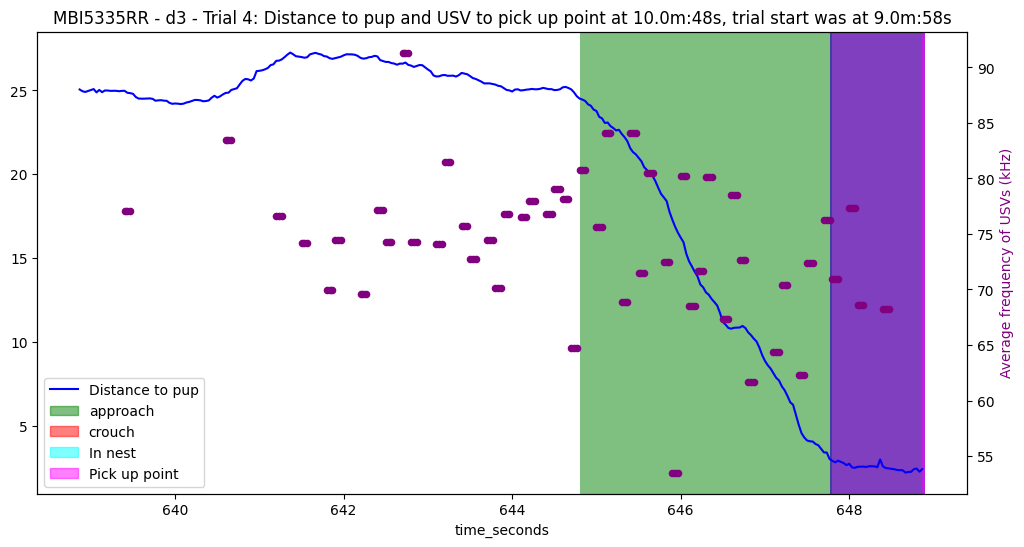

Approach count: 70
Crouching count: 40
Caring count: 40


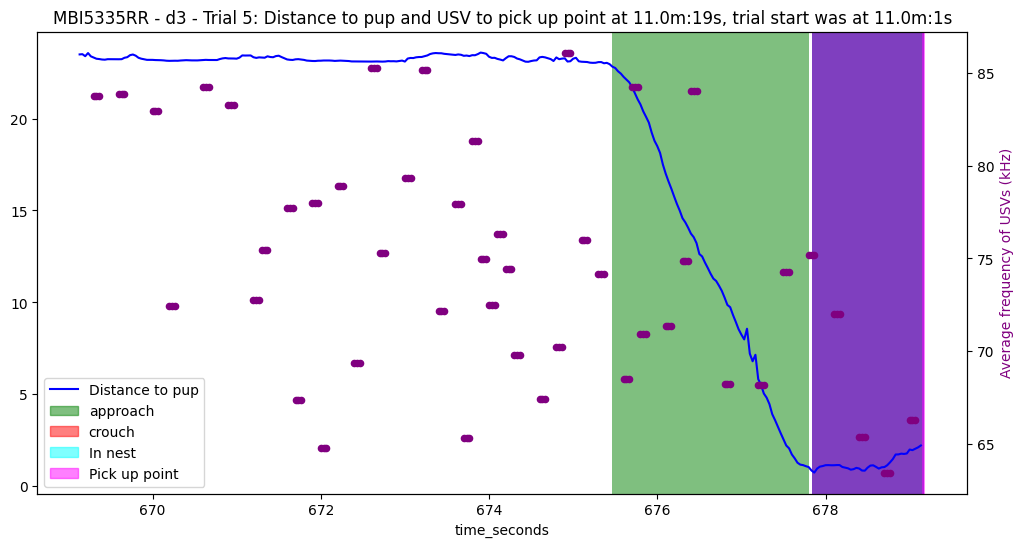

No pick up point for trial 6
Approach count: 86
Crouching count: 36
Caring count: 36


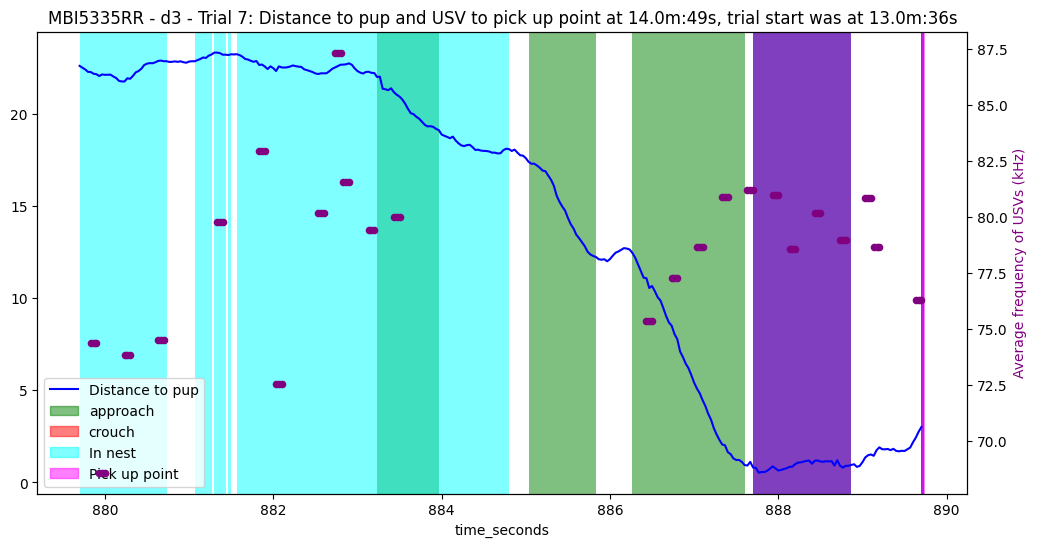

No pick up point for trial 8
Approach count: 50
Crouching count: 69
Caring count: 69


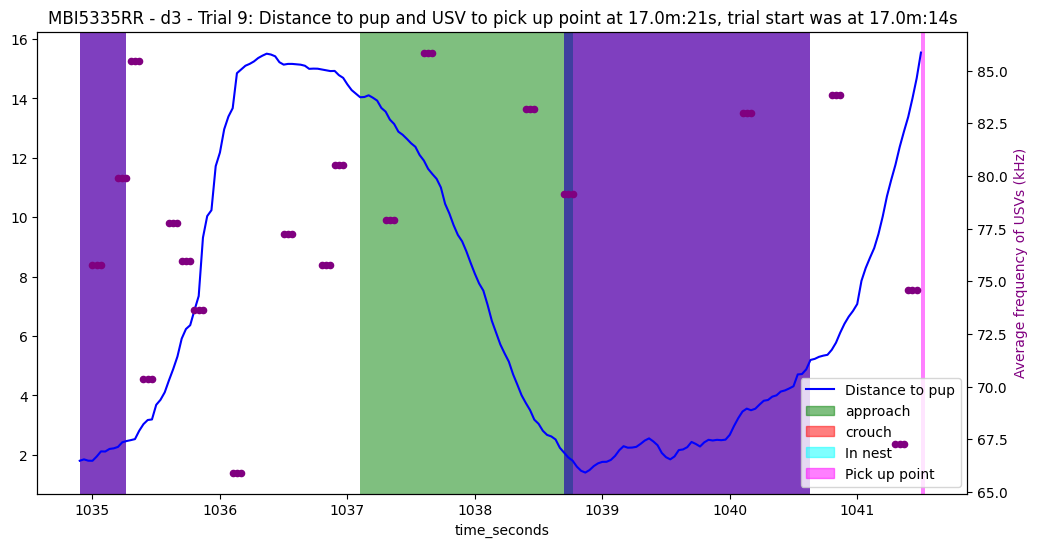

No pick up point for trial 10
Approach count: 95
Crouching count: 36
Caring count: 36


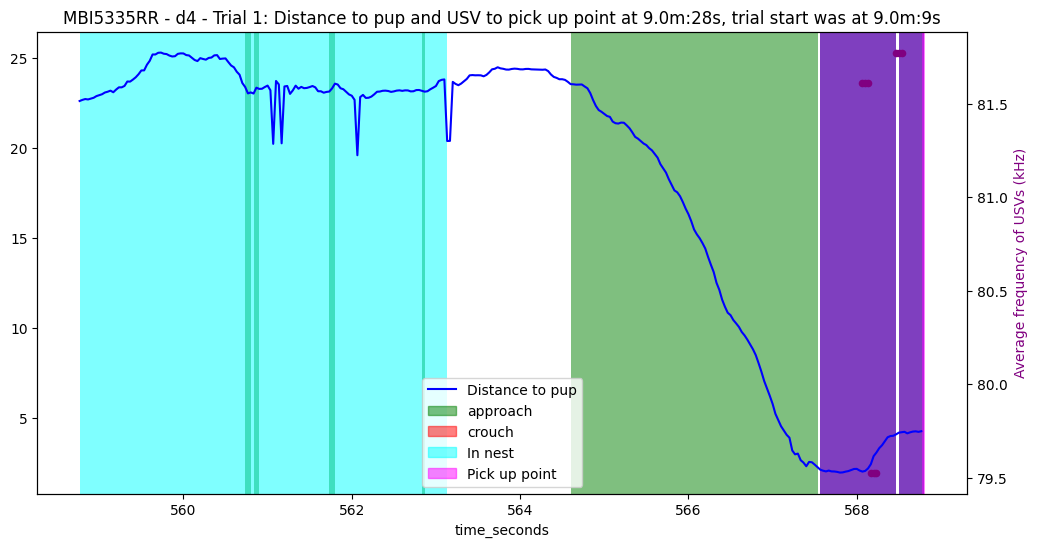

Approach count: 23
Crouching count: 58
Caring count: 60


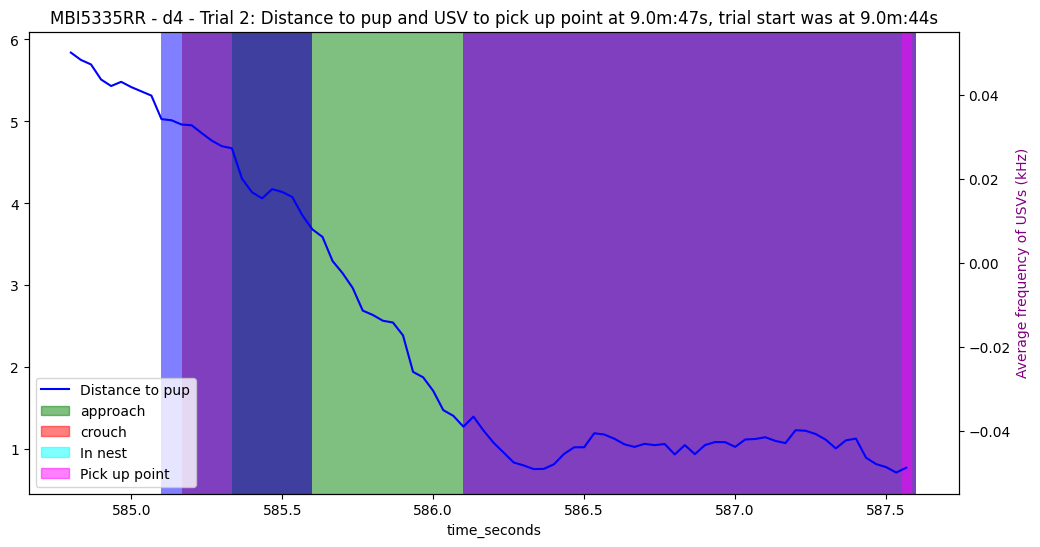

Approach count: 97
Crouching count: 28
Caring count: 28


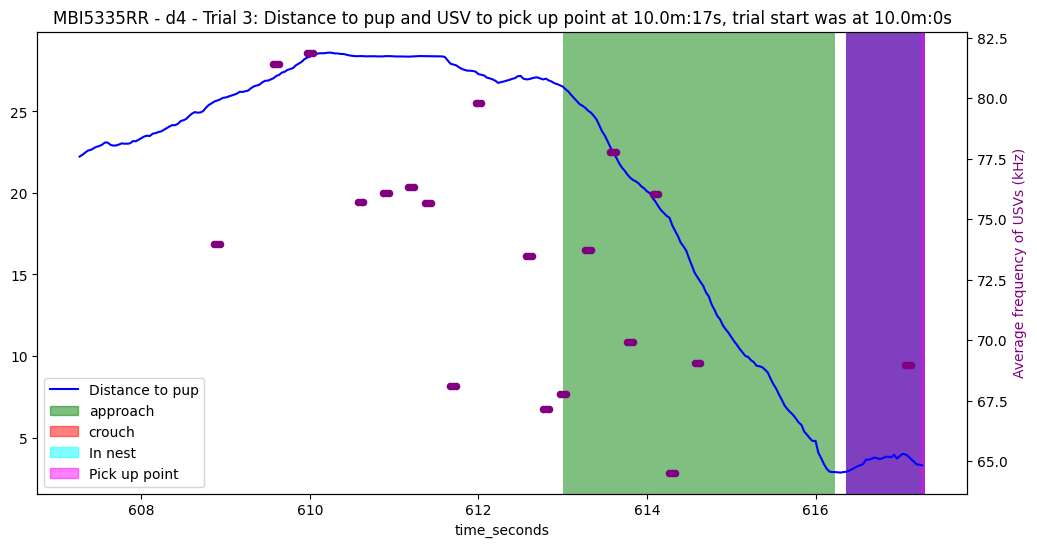

Approach count: 86
Crouching count: 13
Caring count: 13


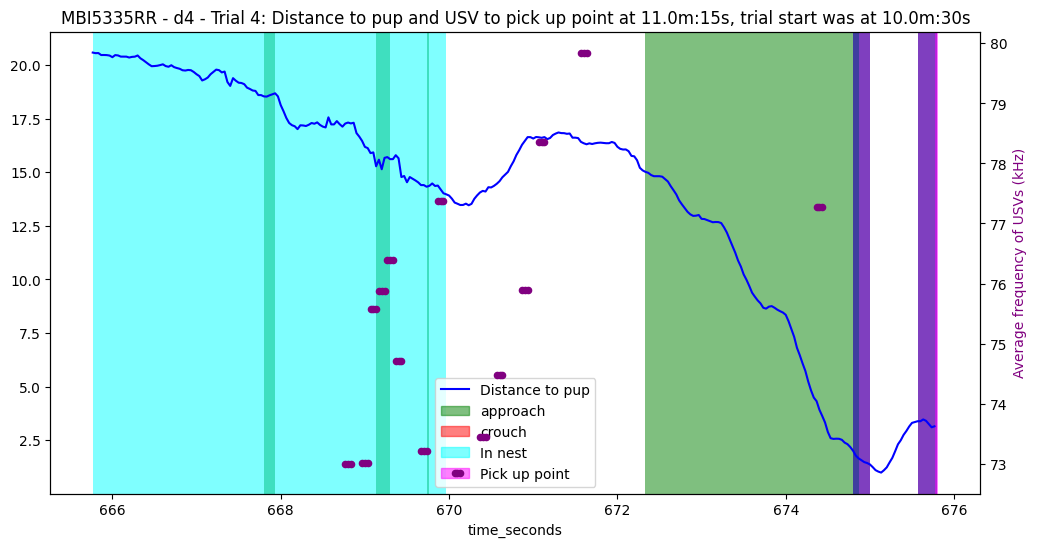

Approach count: 76
Crouching count: 65
Caring count: 65


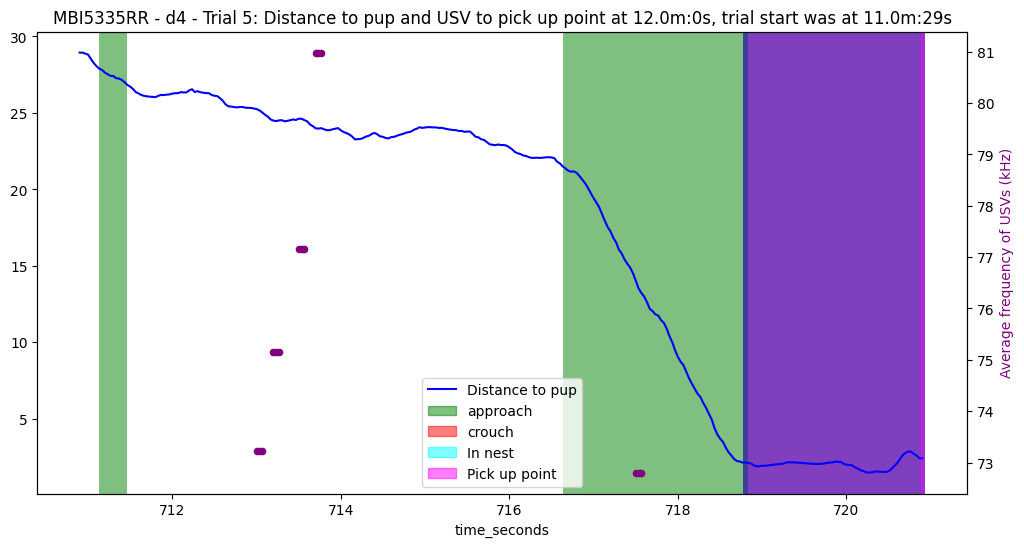

Approach count: 27
Crouching count: 275
Caring count: 275


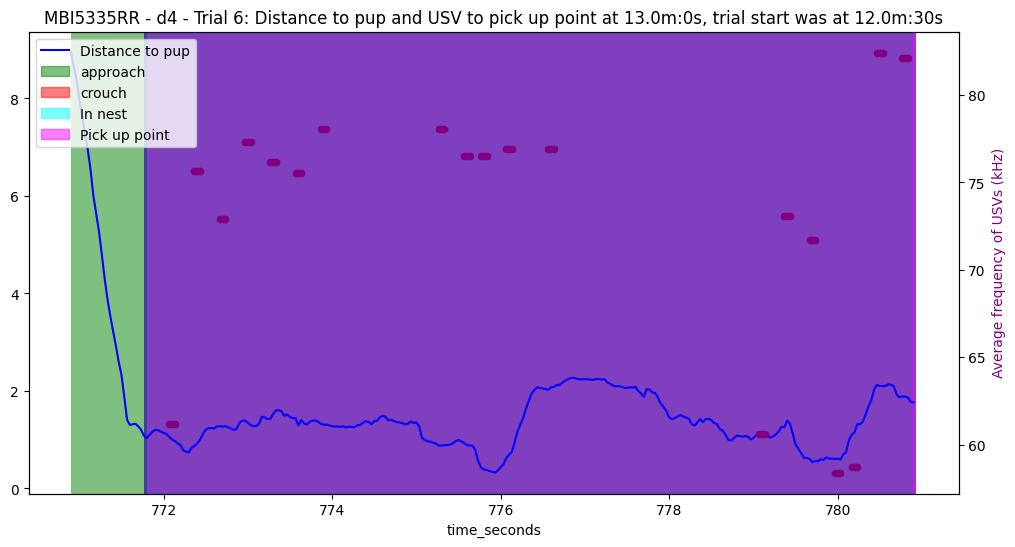

Approach count: 51
Crouching count: 21
Caring count: 21


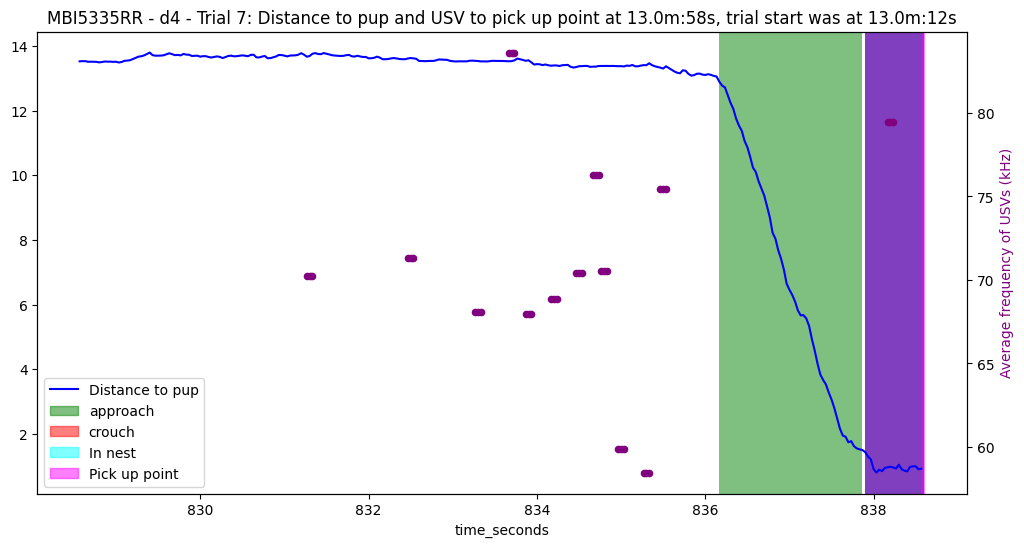

MBI5335RR Day d4 - Trial 8 was not successful
Approach count: 69
Crouching count: 29
Caring count: 30


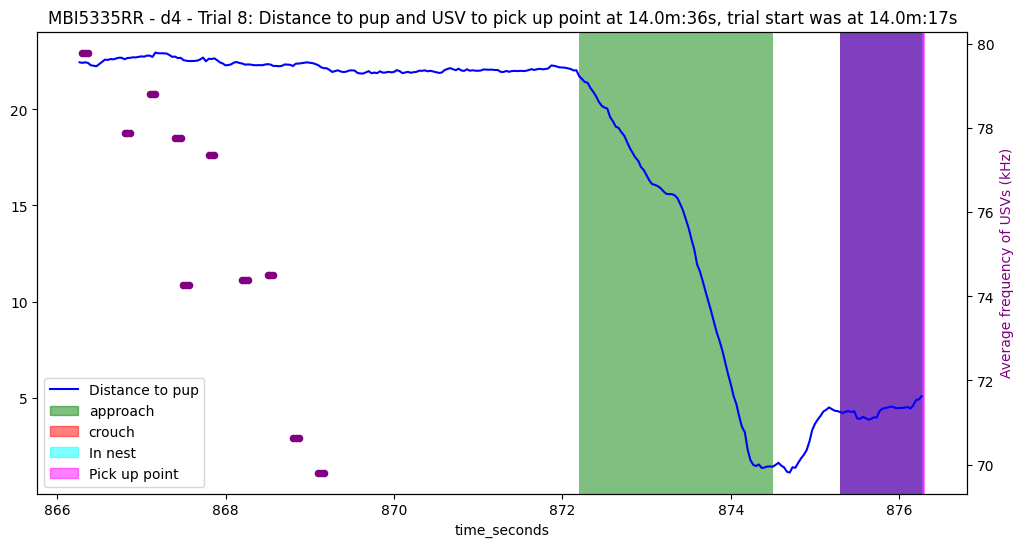

Approach count: 66
Crouching count: 47
Caring count: 47


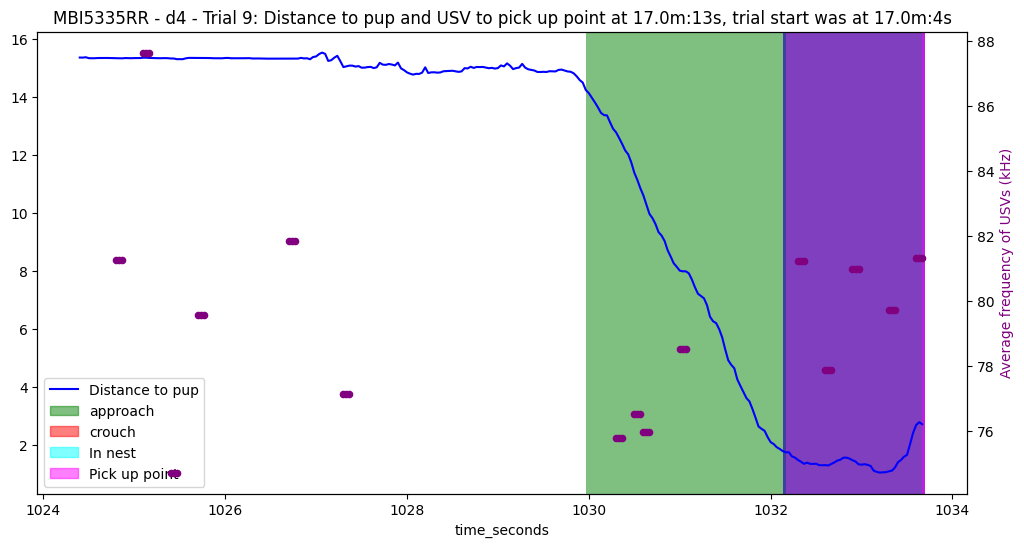

Approach count: 79
Crouching count: 32
Caring count: 38


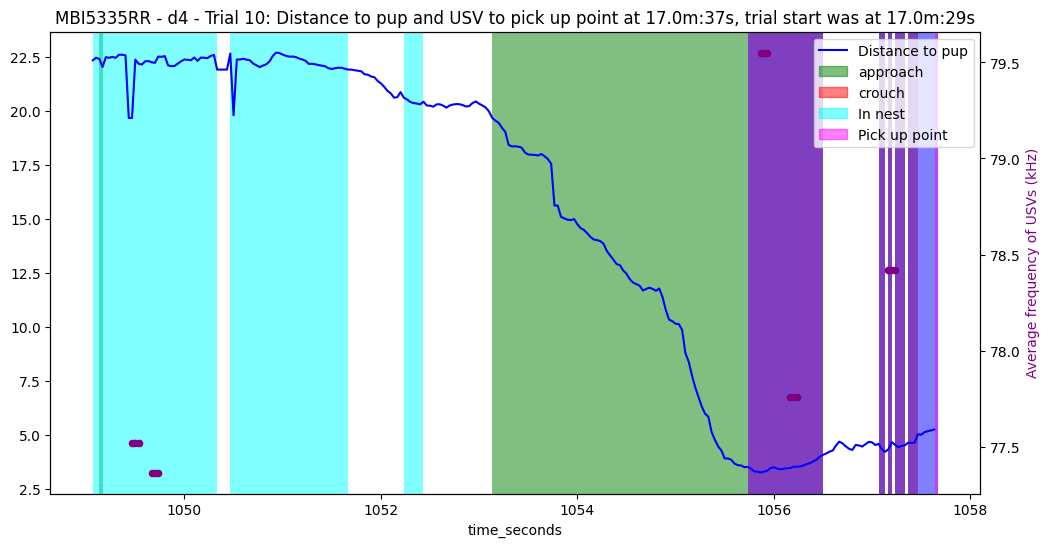

Approach count: 89
Crouching count: 32
Caring count: 32


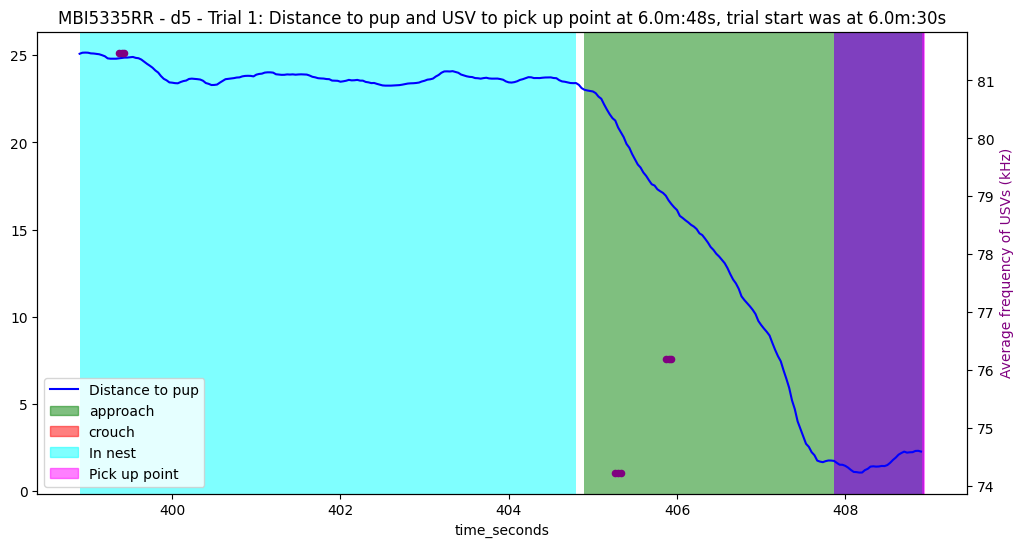

Approach count: 62
Crouching count: 42
Caring count: 42


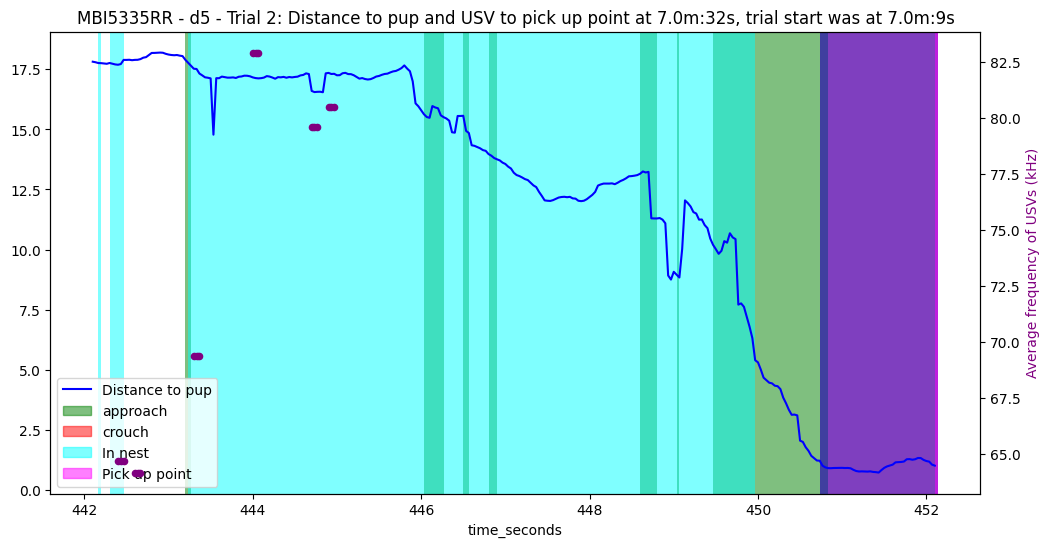

Approach count: 123
Crouching count: 0
Caring count: 12


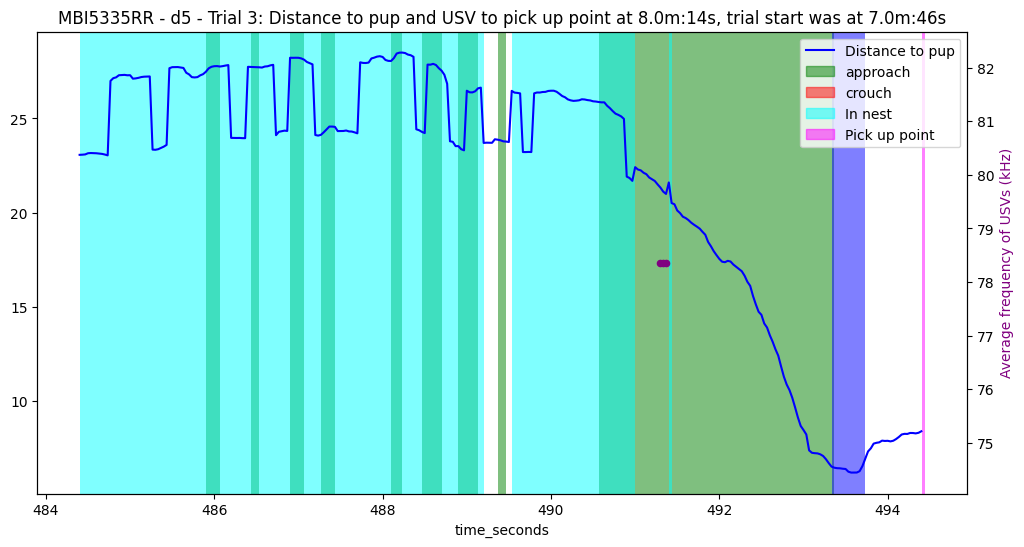

Approach count: 49
Crouching count: 0
Caring count: 0


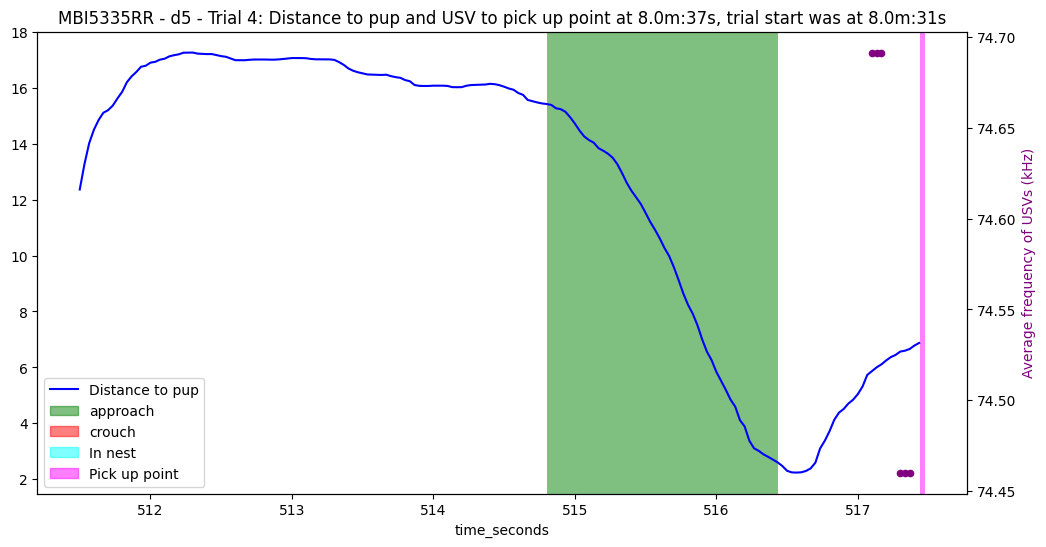

Approach count: 75
Crouching count: 40
Caring count: 40


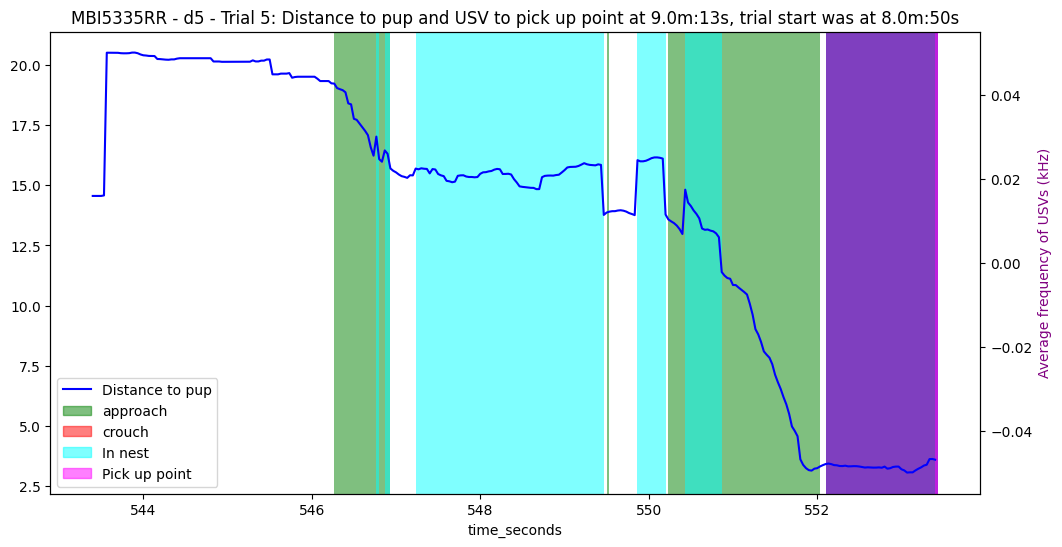

Approach count: 64
Crouching count: 27
Caring count: 27


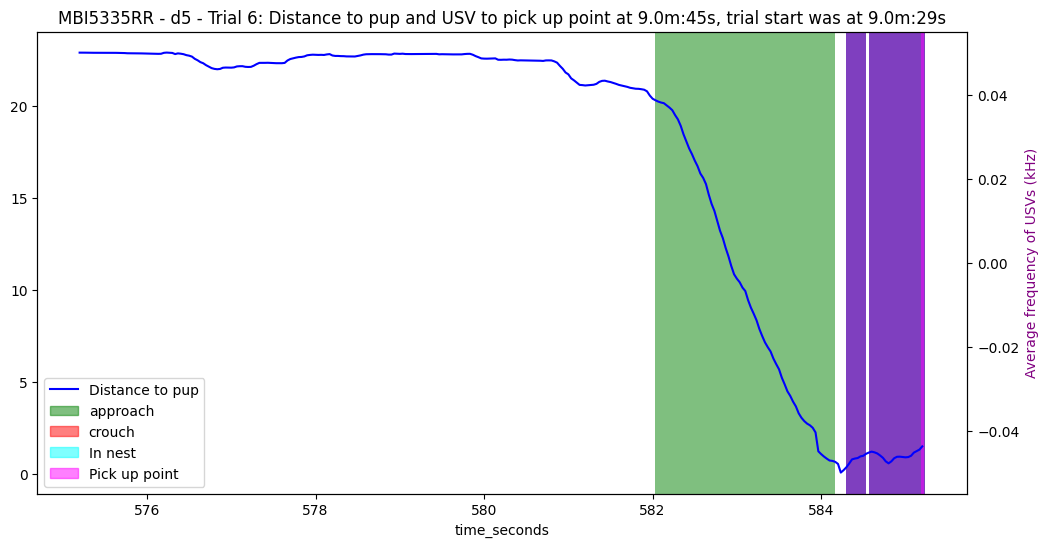

Approach count: 39
Crouching count: 19
Caring count: 19


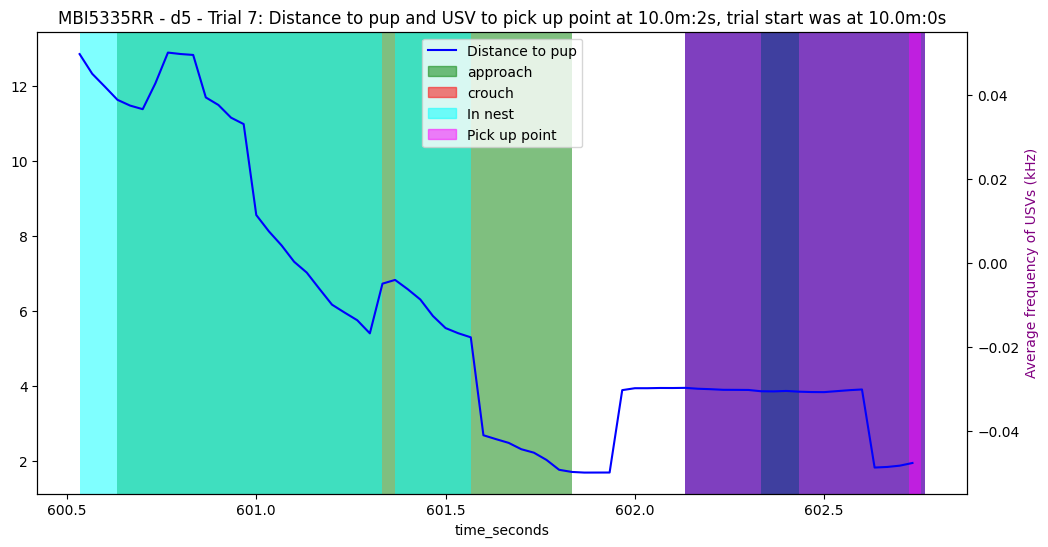

Approach count: 115
Crouching count: 19
Caring count: 19


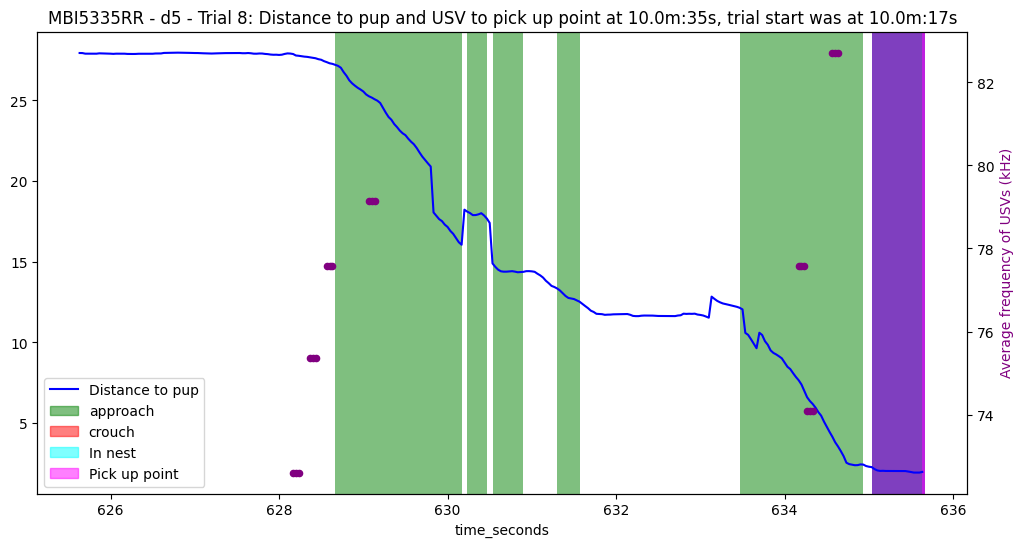

Approach count: 31
Crouching count: 0
Caring count: 0


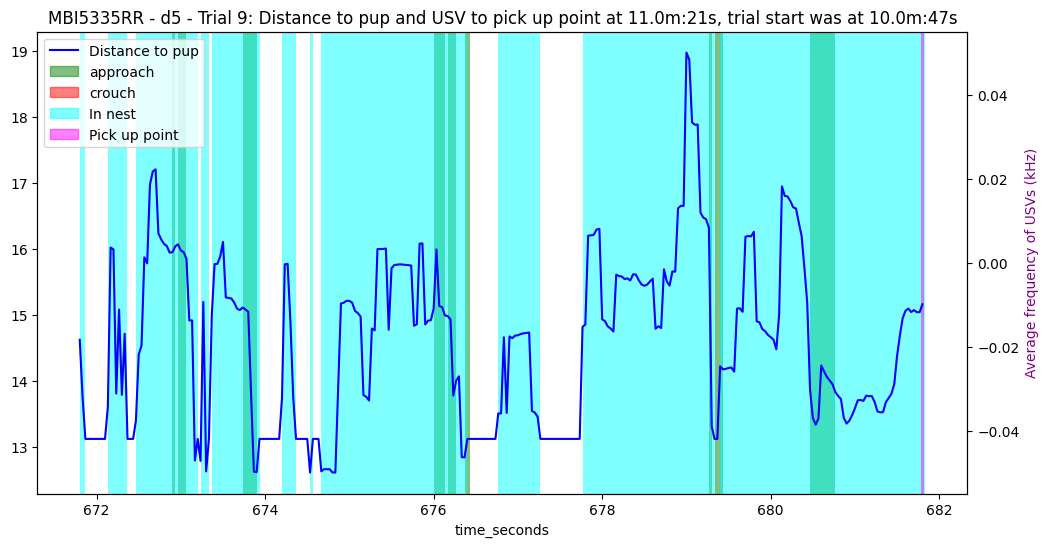

Approach count: 76
Crouching count: 28
Caring count: 28


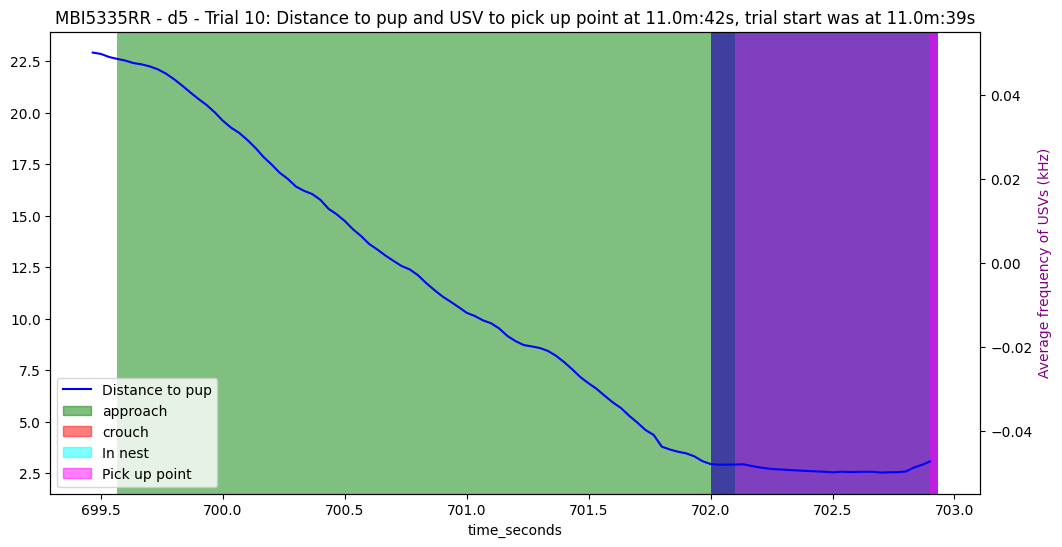

Approach count: 102
Crouching count: 19
Caring count: 19


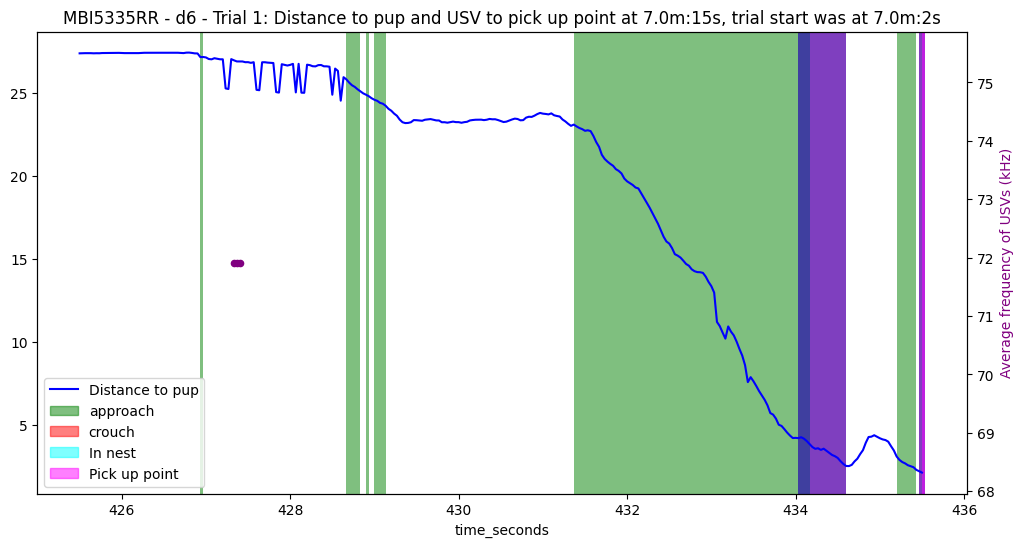

Approach count: 110
Crouching count: 13
Caring count: 13


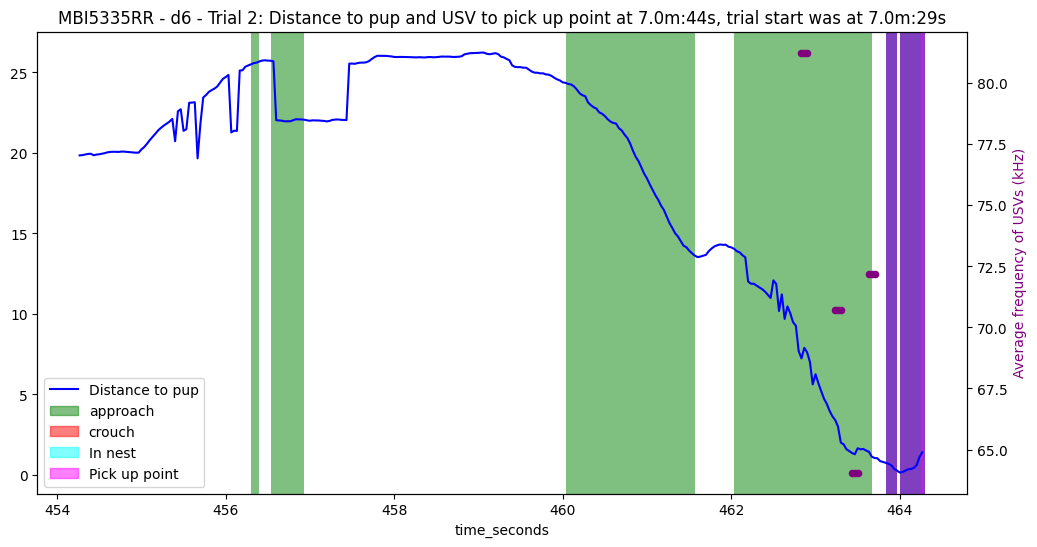

Approach count: 51
Crouching count: 11
Caring count: 11


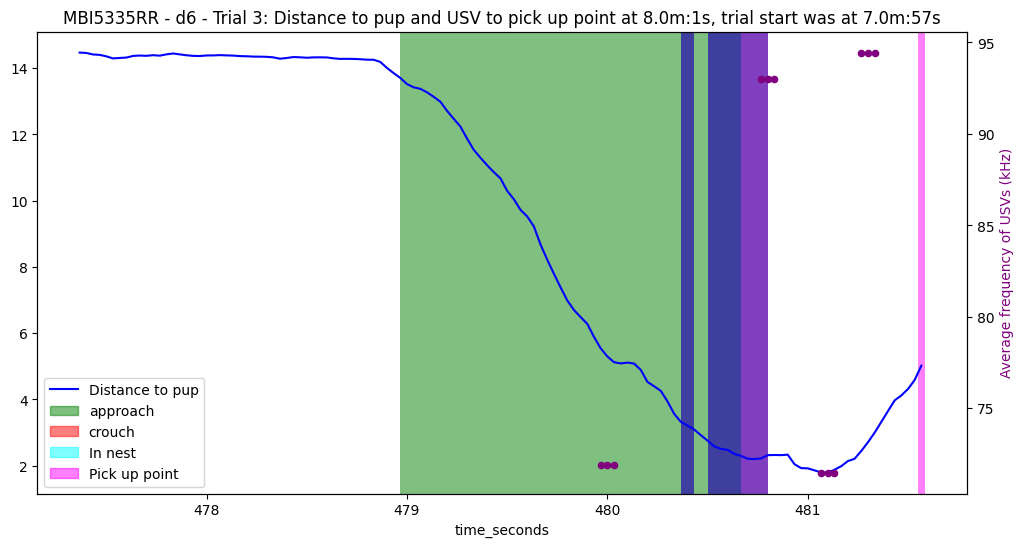

No pick up point for trial 4
Approach count: 0
Crouching count: 103
Caring count: 103


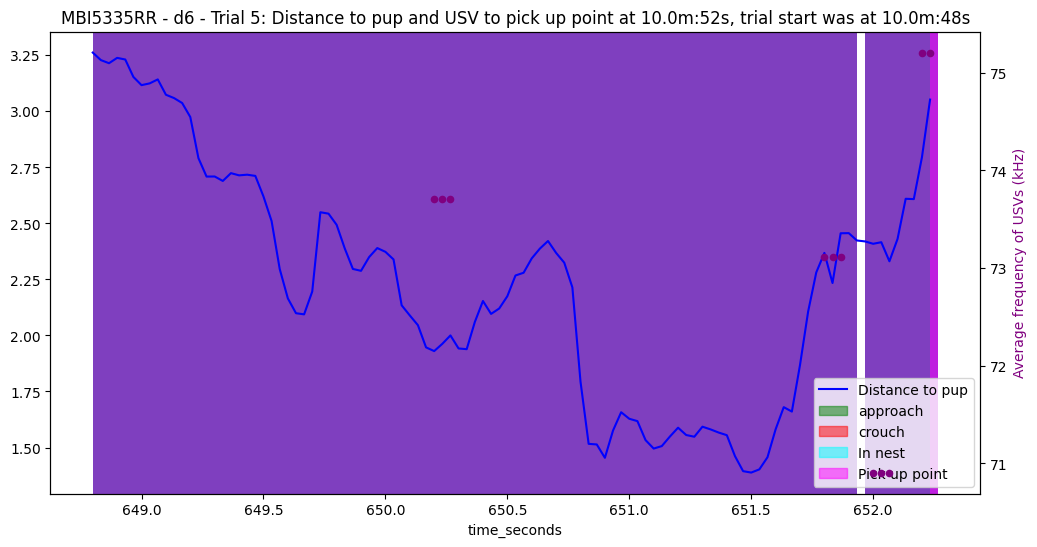

Approach count: 51
Crouching count: 1
Caring count: 1


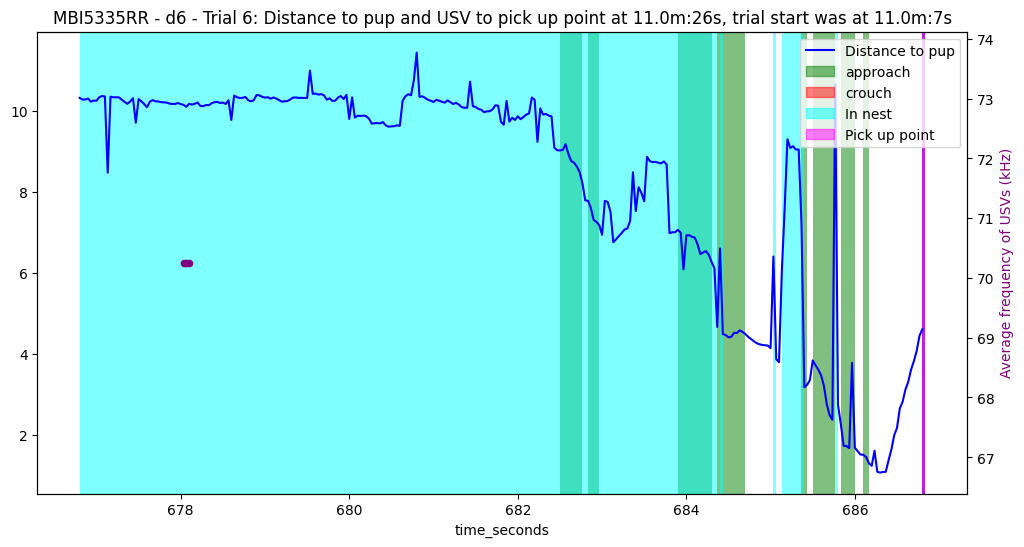

Approach count: 73
Crouching count: 13
Caring count: 13


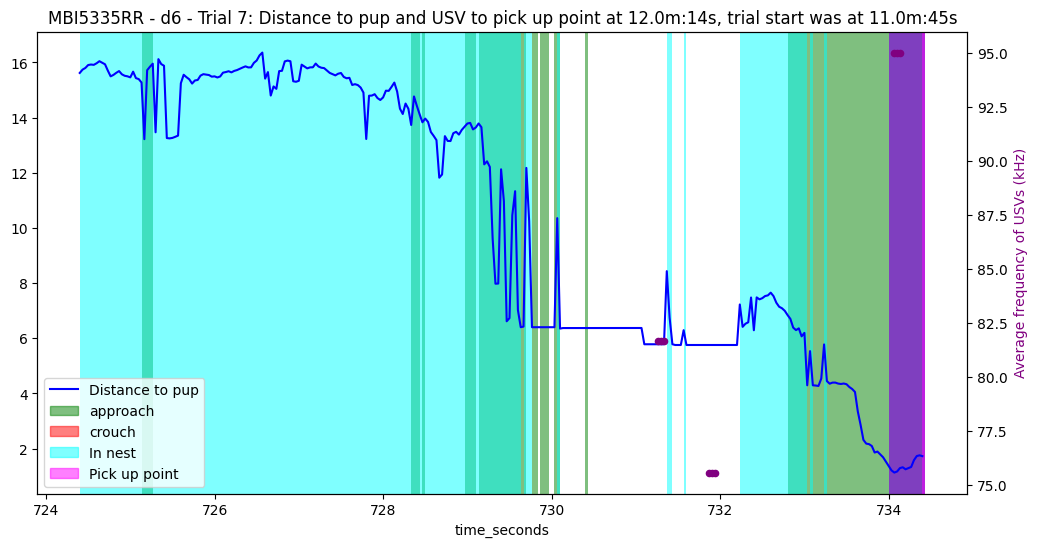

Approach count: 47
Crouching count: 51
Caring count: 51


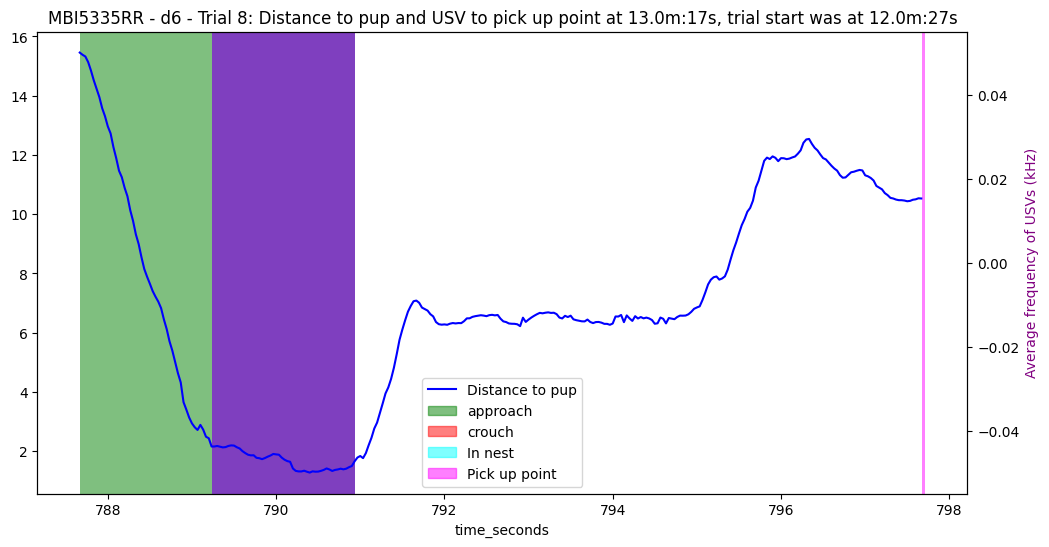

Approach count: 28
Crouching count: 28
Caring count: 6


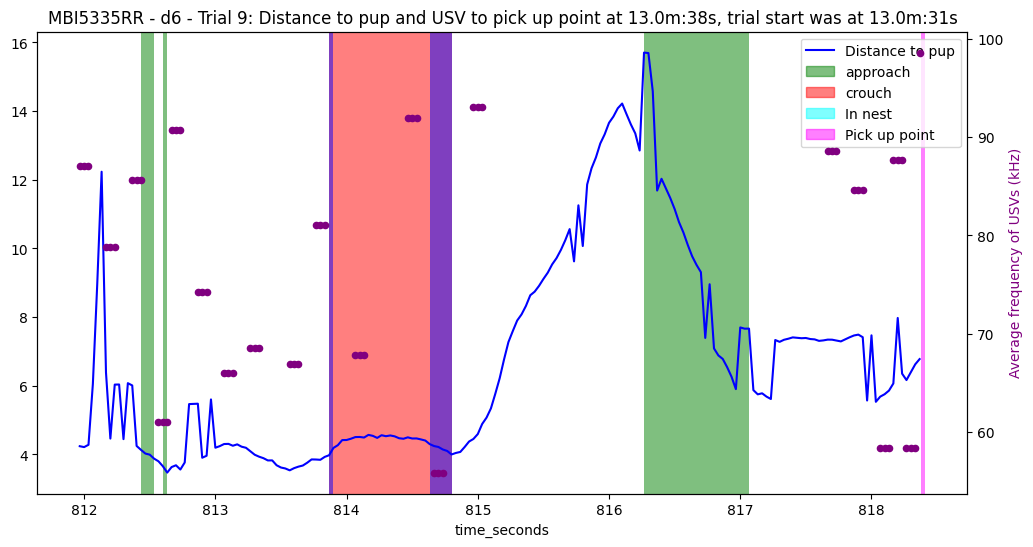

Approach count: 8
Crouching count: 199
Caring count: 199


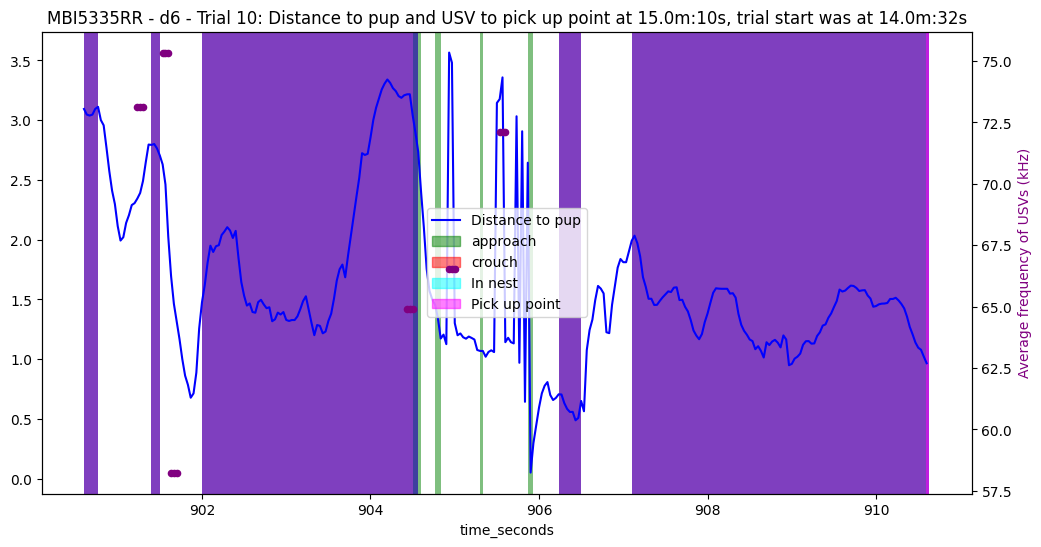

In [11]:
mouse_ids = ["VBQ0261L", "MBI5335RR"]
for ms_id in mouse_ids:
    for d in days:
        for trial_num in range(1, 11):
            # check that the first pick up point is not nan
            df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()
            trial_pickup_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num, BF.DLC_summary_cols["mouse_first_pick_up"]].values[0]
            trial_success =  df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num, BF.DLC_summary_cols["trial_success"]].values[0]

            # maybe should filter for successful trials only?
            if np.isnan(trial_pickup_time):
                print("No pick up point for trial", trial_num)
            elif trial_success == 0:
                print(f"{ms_id} Day {d} - Trial {trial_num} was not successful")
                plot_pup_usv_to_pickup_point(experiment_data, ms_id, d, trial_num)
                plt.show()
            else:
                plot_pup_usv_to_pickup_point(experiment_data, ms_id, d, trial_num)
                plt.show()

### Correlation plots over sessions ###

#### Correlation of distance to pup VS number of calls ####

In [35]:
def extract_trial_window(experiment_data, ms_id, d, trial_num, pre_event_window_size_time = 10):
    
    df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()
    trials = experiment_data[ms_id][d]["trials"].copy()
    trial_DLC = trials[trial_num]["dlc_data"].copy()

    trial_pickup_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
                                       BF.DLC_summary_cols["mouse_first_pick_up"]].values[0]
    trial_start_time = trial_DLC["time_seconds"].iloc[0]
    trial_start_frame_index = trial_DLC["frame_index"].iloc[0]

    # conversion to minutes string
    trial_pickup_time_minutes = f"{int(trial_pickup_time//60)}m:{int(trial_pickup_time%60)}s"
    trial_start_time_minutes = f"{int(trial_start_time//60)}m:{int(trial_start_time%60)}s"

    # conversion to frames
    event_time_point_frame = convert_seconds_to_frame(trial_pickup_time, BF.frame_rate)
    pre_event_window_size_frames = convert_seconds_to_frame(pre_event_window_size_time, BF.frame_rate) # convert to frames 
    start_frame_index = event_time_point_frame - pre_event_window_size_frames

    if start_frame_index < trial_start_frame_index:
        warnings.warn(f"Window is too big, spills over trial start, resetting window size to {trial_start_frame_index - start_frame_index}")
        pre_event_window_size_frames = trial_start_frame_index - start_frame_index

    # compute derivatives for columns in "DLC_behaviour_columns" in the BF over window,  ["mouse_speed", "distance_mouse_pup"]
    window = trial_DLC.loc[start_frame_index:event_time_point_frame].copy()

    # distance mouse to pup corner
    pup_corner_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)
    pup_center_x, pup_center_y = pup_corner_bounds["xmin"] + (pup_corner_bounds["xmax"] - pup_corner_bounds["xmin"]) / 2, pup_corner_bounds["ymin"] + (pup_corner_bounds["ymax"] - pup_corner_bounds["ymin"]) / 2
    window["distance_mouse_pup_center"] = np.sqrt((window["mouse_x"] - pup_center_x)**2 + (window["mouse_y"] - pup_center_y)**2)
    window["distance_head_pup_center"] = np.sqrt((window["head_x"] - pup_center_x)**2 + (window["head_y"] - pup_center_y)**2)

    columns = [BF.DLC_behaviour_cols["mouse_speed"], "distance_mouse_pup_center", "distance_head_pup_center"]
    px_cm_ratio = BF.config["pixels_to_cm_ratio"]
    for col in columns:
        window[col+"_cm"] = window[col] / px_cm_ratio
 
    window[BF.DLC_cols["time"]] =  window[BF.DLC_cols["time"]].iloc[-1] - window[BF.DLC_cols["time"]]

    return window


##### Finding suitable files #####

In [7]:
complex_trials = [("MBI5335RR", "d6", 8),
                  ("MBI5335RR", "d5", 9)]

successful_trials = []
no_pick_up = []
failed_with_pick_up = []

for ms_id in mouse_ids:
    for session in days:
        for trial_num in range(1, 11):
            df_summary = experiment_data[ms_id][session]["Behavior"]["df_summary"].copy()
            trial_pickup_time =  df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num, BF.DLC_summary_cols["mouse_first_pick_up"]].values[0]
            trial_success =  df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num, BF.DLC_summary_cols["trial_success"]].values[0]
            if trial_success == 1:
                successful_trials.append((ms_id, session, trial_num))

            if np.isnan(trial_pickup_time):
                print("No pick up point for trial", trial_num)
                no_pick_up.append((ms_id, session, trial_num))

            elif (ms_id, session, trial_num) in complex_trials:
                print(f"{ms_id} Day {d} - Trial {trial_num} is too complex")

            elif trial_success == 0:
                print(f"{ms_id} Day {d} - Trial {trial_num} was not successful")
                failed_with_pick_up.append((ms_id, session, trial_num))


No pick up point for trial 6
No pick up point for trial 8
No pick up point for trial 10
MBI5335RR Day d6 - Trial 8 was not successful
MBI5335RR Day d6 - Trial 9 is too complex
No pick up point for trial 4
MBI5335RR Day d6 - Trial 8 is too complex
No pick up point for trial 1
No pick up point for trial 2
No pick up point for trial 3
VBQ0261L Day d6 - Trial 4 was not successful
No pick up point for trial 5
No pick up point for trial 6
No pick up point for trial 7
No pick up point for trial 8
VBQ0261L Day d6 - Trial 9 was not successful
No pick up point for trial 10
No pick up point for trial 1
No pick up point for trial 2
No pick up point for trial 3
VBQ0261L Day d6 - Trial 5 was not successful
VBQ0261L Day d6 - Trial 6 was not successful
No pick up point for trial 8
VBQ0261L Day d6 - Trial 10 was not successful
No pick up point for trial 1
No pick up point for trial 2
No pick up point for trial 3
No pick up point for trial 5
VBQ0261L Day d6 - Trial 8 was not successful
No pick up point 

In [11]:
len(failed_with_pick_up)

8

In [13]:
# count of sucessful trials
print("Virgin success trials count:", len([t for t in successful_trials if t[0] != "MBI5335RR"]))

print("Mother success trials count:", len([t for t in successful_trials if t[0] == "MBI5335RR"]))

# count of failed trials with attempted pick up
print("Virgin failed trials (with pick up) count:", len([t for t in failed_with_pick_up if t[0] != "MBI5335RR"]))

print("Mother failed trials (with pick up) count:", len([t for t in failed_with_pick_up if t[0] == "MBI5335RR"]))

Virgin success trials count: 20
Mother success trials count: 54
Virgin failed trials (with pick up) count: 7
Mother failed trials (with pick up) count: 1


In [36]:
triple = ("MBI5335RR", "d5", 9)

extract_trial_window(experiment_data, *triple)

frame_index  time_seconds      nose_x     nose_y  nose_likelihood  \
20154        20154     10.000000  338.228790  38.889061         0.126245   
20155        20155      9.966667  338.228790  38.889061         0.125414   
20156        20156      9.933333  271.654785  37.861618         0.126525   
20157        20157      9.900000  271.654785  37.861618         0.124263   
20158        20158      9.866667  271.654785  37.861618         0.121263   
...            ...           ...         ...        ...              ...   
20450        20450      0.133333  302.876617  31.947258         0.879511   
20451        20451      0.100000  302.157074  31.670891         0.876731   
20452        20452      0.066667  302.031891  31.670891         0.843057   
20453        20453      0.033333  301.699127  31.670891         0.825927   
20454        20454      0.000000  301.001526  31.518875         0.815798   

       earRight_x  earRight_y  earRight_likelihood   earLeft_x  earLeft_y  \
20154  228.050095   34.383404             0.074674  327.190369  34.154556   
20155  228.050095   34.417107             0.043761  327.190369  34.154556   
20156  282.115173   24.928495             0.012147  288.323639  35.700634   
20157  282.115173   24.928495             0.011544  288.323639  35.700634   
20158  282.115173   24.928495             0.012165  288.323639  35.700634   
...           ...         ...                  ...         ...        ...   
20450  285.906799   37.437664             0.947482  283.541595  28.726362   
20451  285.319580   37.437664             0.939211  283.394867  28.726362   
20452  283.262299   37.189236             0.932435  282.053894  28.726362   
20453  282.988861   37.189236             0.932931  281.997223  28.286901   
20454  282.880341   37.058887             0.965729  281.448181  28.003269   

       ...  bout_window_index  call_number  average_power  average_frequency  \
20154  ...              239.0          NaN            NaN                NaN   
20155  ...              240.0          NaN            NaN                NaN   
20156  ...              240.0          NaN            NaN                NaN   
20157  ...              240.0          NaN            NaN                NaN   
20158  ...              241.0          NaN            NaN                NaN   
...    ...                ...          ...            ...                ...   
20450  ...              338.0          NaN            NaN                NaN   
20451  ...              338.0          NaN            NaN                NaN   
20452  ...              339.0          NaN            NaN                NaN   
20453  ...              339.0          NaN            NaN                NaN   
20454  ...              339.0          NaN            NaN                NaN   

       average_duration  distance_mouse_pup_center  distance_head_pup_center  \
20154               NaN                 152.332367                161.768107   
20155               NaN                 143.336399                161.989358   
20156               NaN                 136.686848                160.504536   
20157               NaN                 136.686848                160.504536   
20158               NaN                 136.686848                160.504536   
...                 ...                        ...                       ...   
20450               NaN                 156.721096                144.728678   
20451               NaN                 157.010705                145.133492   
20452               NaN                 156.700685                146.491787   
20453               NaN                 156.677114                146.800681   
20454               NaN                 157.930299                147.311593   

       mouse_speed_px/s_cm  distance_mouse_pup_center_cm  \
20154            33.920502                     14.619229   
20155            22.152686                     13.755892   
20156             0.000000                     13.117740   
20157  

In [45]:
bins = [(i, i+2) for i in range(0, 10, 2)]

trials = successful_trials + failed_with_pick_up #[successful_trials[8]]

correlation_data = { "MBI5335RR": {day:[] for day in days},
                    "VBQ0261L": {day:[] for day in days}}

for t in trials:
    # extract window
    df = extract_trial_window(experiment_data, *t)

    ms_id, session, trial_num = t

    for b in bins:

        min, max = b
        mask = (df["time_seconds"] >= min) & (df["time_seconds"] <= max)
        window_bin = df[mask]

        if window_bin["time_seconds"].sum() == 0:
            length = df["time_seconds"].iloc[0]
            print(f"Bin {b} is empty, trial too short with total length {length} seconds")
            continue

        else:
            groups = window_bin.groupby("bout_window_index")
            # aggregating call numbers over groups
            call_numbers = [g["call_number"].iloc[0] for name, g in groups if g["call_number"].isna().sum() == 0]
            total_call_numbers = sum(call_numbers)
            # compute average distance
            avg_distance = window_bin["distance_mouse_pup_center_cm"].mean()

            correlation_data[ms_id][session].append((total_call_numbers, avg_distance))

            print(f"Bin {b}, Trial {t} => (x: {total_call_numbers}, y: {avg_distance})")


    

Bin (0, 2), Trial ('MBI5335RR', 'd1', 1) => (x: 0, y: 1.5228267063608603)
Bin (2, 4), Trial ('MBI5335RR', 'd1', 1) => (x: 0, y: 7.359141882618541)
Bin (4, 6), Trial ('MBI5335RR', 'd1', 1) => (x: 0, y: 21.627325239459598)
Bin (6, 8), Trial ('MBI5335RR', 'd1', 1) => (x: 3.0, y: 26.43873419234177)
Bin (8, 10), Trial ('MBI5335RR', 'd1', 1) => (x: 0, y: 26.862002138171093)
Bin (0, 2), Trial ('MBI5335RR', 'd1', 2) => (x: 0, y: 1.4772832071564417)
Bin (2, 4), Trial ('MBI5335RR', 'd1', 2) => (x: 0, y: 5.367835600664958)
Bin (4, 6) is empty, trial too short with total length 2.966666666666697 seconds
Bin (6, 8) is empty, trial too short with total length 2.966666666666697 seconds
Bin (8, 10) is empty, trial too short with total length 2.966666666666697 seconds
Bin (0, 2), Trial ('MBI5335RR', 'd1', 3) => (x: 0, y: 2.66597392759591)
Bin (2, 4), Trial ('MBI5335RR', 'd1', 3) => (x: 0, y: 6.751492280178406)
Bin (4, 6), Trial ('MBI5335RR', 'd1', 3) => (x: 0, y: 9.385112033109445)
Bin (6, 8), Trial ('

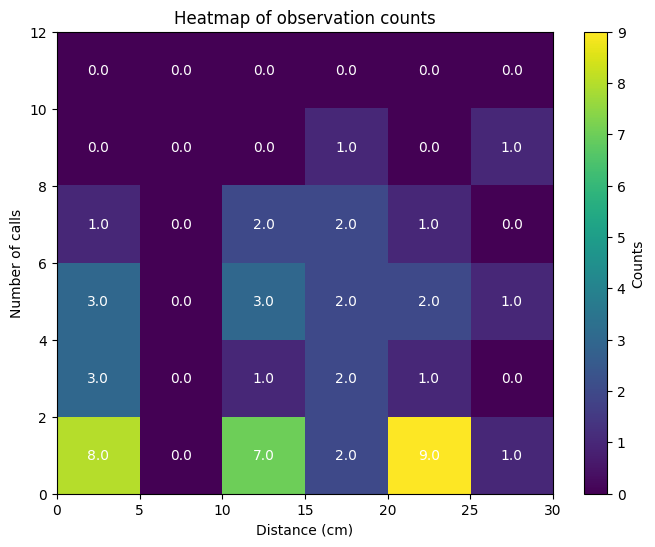

Text(0, 0.5, 'Number of calls')

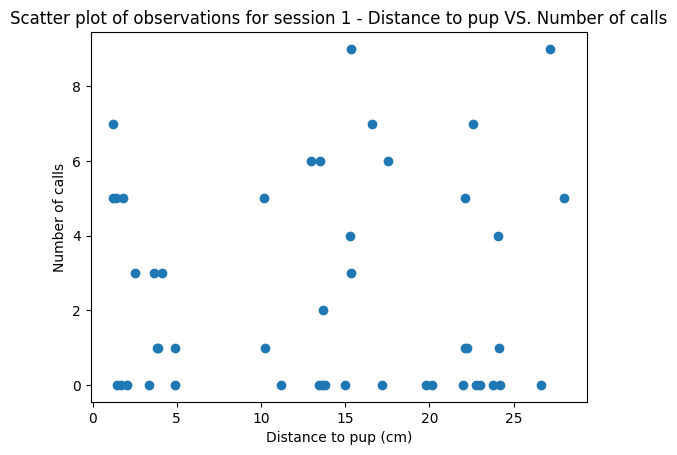

In [105]:
data_d1_M = correlation_data['MBI5335RR']['d4'].copy()
data_d1_M = np.array(data_d1_M)


def create_matrix(data):

    bins_distance = [(i, i+5) for i in range(0, 30, 5)]
    bins_numcalls = [(i, i+2) for i in range(0, 12, 2)]

    data = np.array(data)
    matrix_data = np.zeros((len(bins_numcalls), len(bins_distance)))

    for i in range(len(bins_numcalls)):
        for j in range(len(bins_distance)):

            mask = (data[:,1] >= bins_distance[j][0]) & (data[:,1] <= bins_distance[j][1]) & (data[:,0] >= bins_numcalls[i][0]) & (data[:,0] <= bins_numcalls[i][1])
            # print("for distance bin {} and numcalls bin {} count is {}".format(bins_distance[j], bins_numcalls[i], mask.sum()))
            matrix_data[i,j] = mask.sum() # count of observations in ith num call bin, in jth distance bin

    return matrix_data


#### Matrix plot ####
# show matrix_data as heatmap of colors
# Define x and y axis labels
x_labels = [0, 5, 10, 15, 20, 25, 30]
y_labels = [0, 2, 4, 6, 8, 10, 12]

matrix_data = create_matrix(data_d1_M)

# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(matrix_data,
        cmap='viridis',
        aspect='auto',
        origin = "lower")

# Add color bar
cbar = plt.colorbar()
cbar.set_label('Counts')

# Set axis ticks and labels
plt.xticks(ticks=np.arange(0, matrix_data.shape[1] + 1) - 0.5, labels=x_labels)
plt.yticks(ticks=np.arange(0, matrix_data.shape[0] + 1) - 0.5, labels=y_labels)

# Add labels to each cell
for i in range(matrix_data.shape[0]):
    for j in range(matrix_data.shape[1]):
        plt.text(j, i, str(matrix_data[i, j]), ha='center',
                va='center', color='white')

# Add axis labels
plt.xlabel('Distance (cm)')
plt.ylabel('Number of calls')
plt.title('Heatmap of observation counts')

# Show the plot
plt.show()


plt.show()

plt.scatter(data_d1_M[:,1], data_d1_M[:,0])
plt.title("Scatter plot of observations for session 1 - Distance to pup VS. Number of calls")
plt.xlabel("Distance to pup (cm)")
plt.ylabel("Number of calls")

Overview plots

Correlation for MBI5335RR, d1 is 0.166
Correlation for MBI5335RR, d2 is 0.198
Correlation for MBI5335RR, d3 is 0.441
Correlation for MBI5335RR, d4 is 0.02
Correlation for MBI5335RR, d5 is 0.057
Correlation for MBI5335RR, d6 is -0.397
Correlation for VBQ0261L, d1 is nan
Correlation for VBQ0261L, d2 is 0.33
Correlation for VBQ0261L, d3 is 0.313
Correlation for VBQ0261L, d4 is 0.07
Correlation for VBQ0261L, d5 is 0.053
Correlation for VBQ0261L, d6 is 0.649


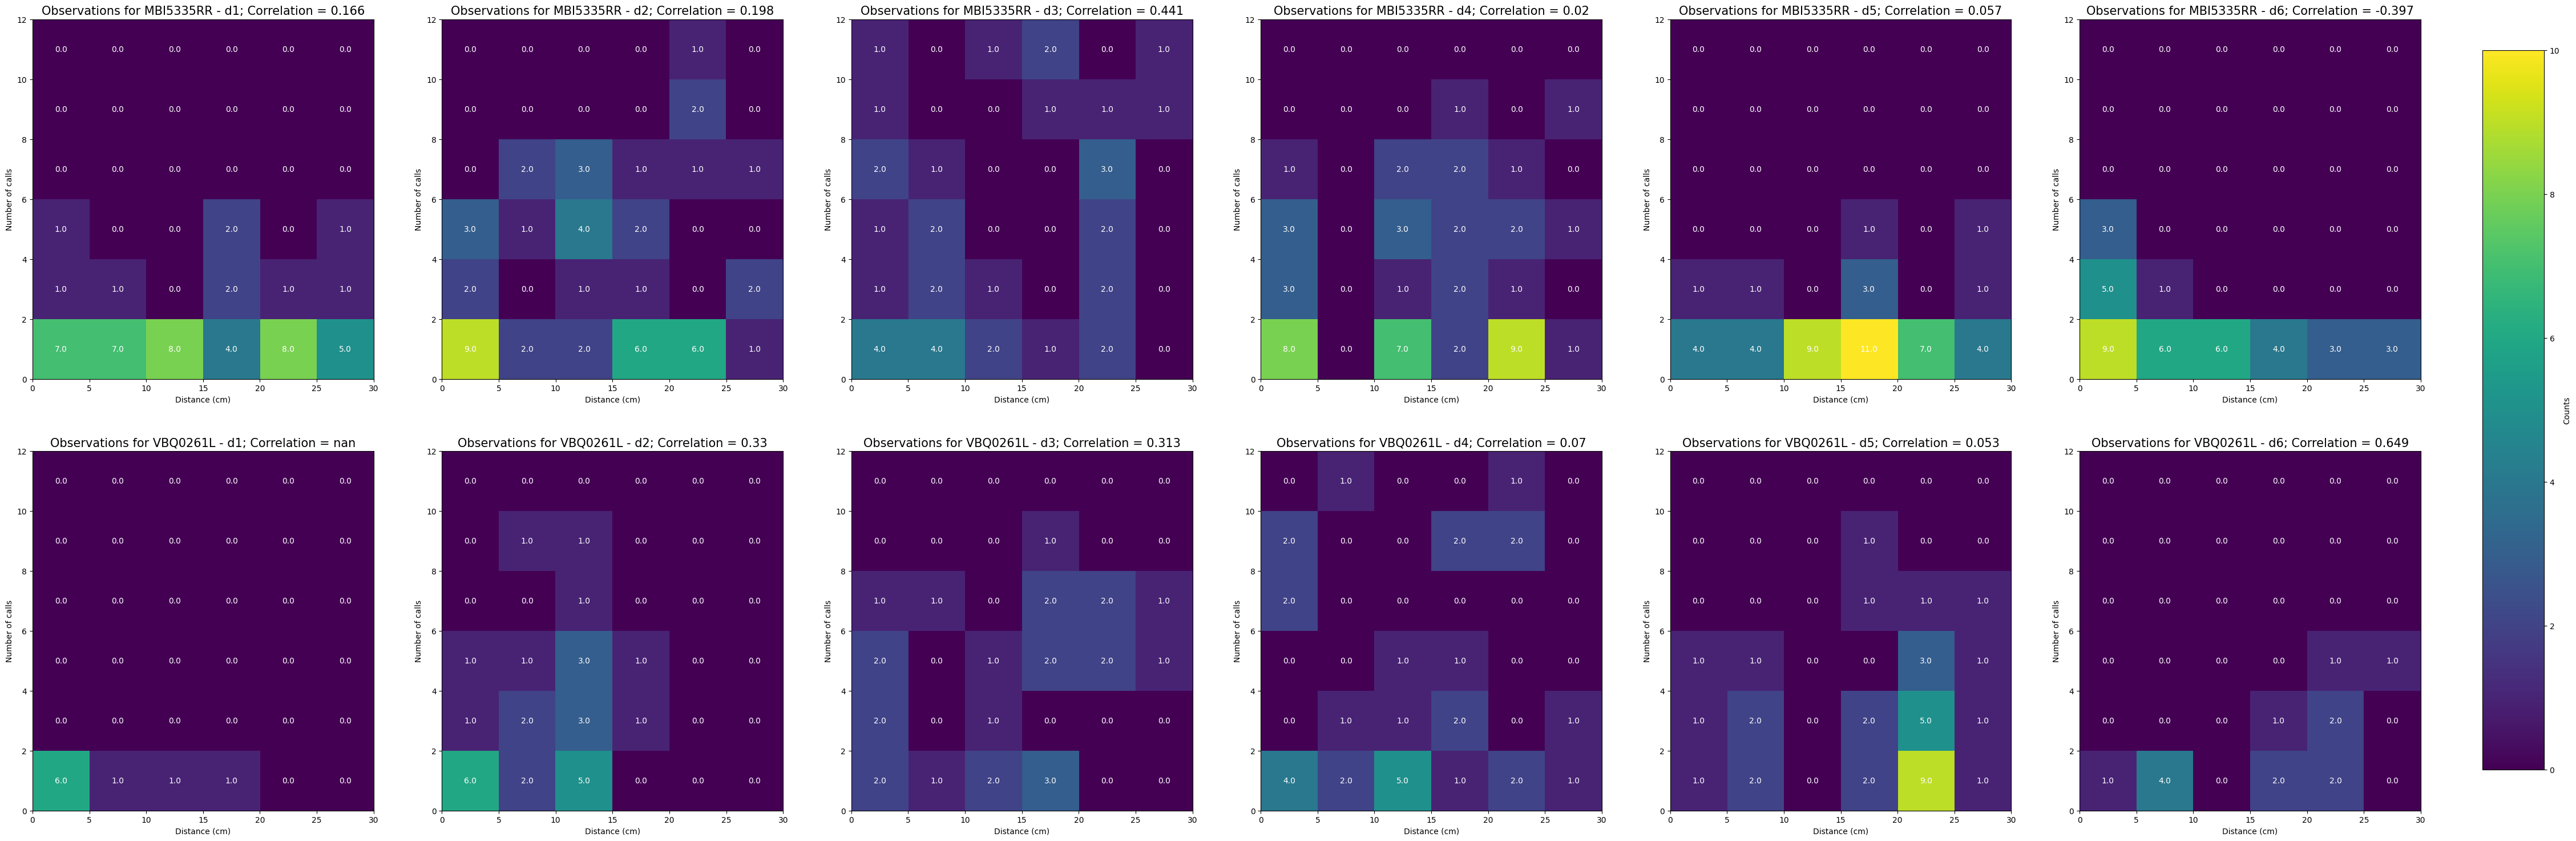

In [134]:
# create a 2 x 6 plots, each plot is a matrix of counts

fig, axs = plt.subplots(2, 6, figsize = (45*1.2, 15*1.2))

for i in range(2):
    ms_id = mouse_ids[i]
    for j in range(6):
        session = days[j]

        data = correlation_data[ms_id][session].copy()
        data =  np.array(data)

        # compute the correlation of the data
        corr = np.corrcoef(data[:,0], data[:,1])
        # show only 3 digits after the decimal
        corr = np.round(corr, 3)
        print(f"Correlation for {ms_id}, {session} is {corr[0,1]}")

        matrix_data = create_matrix(data)

        # create plot
        ax = axs[i, j]

        im = ax.imshow(matrix_data,
                cmap='viridis',
                aspect='auto',
                origin = "lower",
                vmin = 0, vmax = 10)

        # # Add color bar
        # cbar = ax.colorbar()
        # cbar.set_label('Counts')

        # Set axis ticks and labels
        ax.set_xticks(ticks=np.arange(0, matrix_data.shape[1] + 1) - 0.5, labels=x_labels)
        ax.set_yticks(ticks=np.arange(0, matrix_data.shape[0] + 1) - 0.5, labels=y_labels)

        # Add labels to each cell
        for k in range(matrix_data.shape[0]):
            for l in range(matrix_data.shape[1]):
                ax.text(l, k, str(matrix_data[k, l]), ha='center',
                        va='center', color='white')

        # Add axis labels
        ax.set_xlabel('Distance (cm)')
        ax.set_ylabel('Number of calls')
        ax.set_title(f'Observations for {ms_id} - {session}; Correlation = {corr[0,1]}', fontsize = 15)
    

# add a colorbar at the end of the row
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of the colorbar
fig.colorbar(im, cax=cbar_ax, label='Counts')

